# Light Curve Parameter Inference Using LFI -- Tutorial

# Imports

## Python Packages

In [1]:
# general modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib.lines as mlines
import os, sys, time, glob
import json
import copy
import scipy
import warnings
from tqdm import tqdm

In [2]:
# pytorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset, random_split
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter

In [3]:
# bilby
import bilby
from bilby.core.prior import Uniform, DeltaFunction
from bilby.core.likelihood import GaussianLikelihood

In [4]:
# nflows
from nflows.nn.nets.resnet import ResidualNet
from nflows import transforms, distributions, flows
from nflows.distributions import StandardNormal
from nflows.flows import Flow
from nflows.transforms.autoregressive import MaskedAffineAutoregressiveTransform
from nflows.transforms import CompositeTransform, RandomPermutation
import nflows.utils as torchutils

In [5]:
# extras
from IPython.display import clear_output
from time import time
from time import sleep
import corner
import torchvision
import torchvision.transforms as transforms
from os.path import exists

## Personal Functions

In [6]:
# importing dataloading functions

# these functions are used to open the data and assign data id's
from data_processing import open_json, get_names, json_to_df, add_batch_sim_nums_all, get_test_names

# these functions are used to ensure the data are the same length (121 points)
from data_processing import gen_prepend_filler, gen_append_filler, pad_the_data, pad_all_dfs

# these functions are used to read in data when it is in csv format
from data_processing import load_in_data, match_fix_to_var, matched

# these functions are used to convert csv files to tensors and create a dataset
from data_processing import repeated_df_to_tensor, Paper_data

In [7]:
# importing similarity embedding functions

from embedding import VICRegLoss, ConvResidualBlock, ConvResidualNet, SimilarityEmbedding, train_one_epoch_se, val_one_epoch_se

# importing resnet from ML4GW pe

from resnet import ResNet

In [8]:
# importing normalizing flow functions

from normalizingflows import Flow_data, EmbeddingNet, normflow_params, train_one_epoch, val_one_epoch

In [9]:
# importing inference functions

from inference import cast_as_bilby_result, live_plot_samples, ppplot, comparison_plot

## Setting Device

In [10]:
# checking gpu status, ensures tensors are stored on the same device

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device}")

Using cuda


# Data Specific Parameters and Priors

Light curve generation is done through the nmma package on github: https://github.com/nuclear-multimessenger-astronomy/nmma/tree/main. To properly encode the effects of changing $t$ and $d_L$, each combination of our physical parameters $\log_{10}(M_{ej})$, $\log_{10}(V_{ej})$, and $\log_{10}(X_{lan})$ are repeated 50 times to produce light curves with unique noise instances. A second set of 50 light curves is created by adjusting $t$ and $d_L$ according to the priors shown below. Our training dataset contains 8,729 unique combinations of $\log_{10}(M_{ej})$, $\log_{10}(V_{ej})$, and $\log_{10}(X_{lan})$, resulting in $8,729 \times 50 \times 2 = 872,900$ total light curves.

In [11]:
# json specific parameters, adjust this cell with commands when generating light curves -- MANDATORY

bands = ['ztfg', 'ztfr', 'ztfi']
detection_limit = 22.0
num_repeats = 50
num_channels = 3
num_points = 121
in_features = num_points
data_dir = '/nobackup/users/mmdesai/new_csv/'

In [12]:
# time shift

t_zero = 44242.00021937881
t_min = 44240.00050450478
t_max = 44269.99958898723
days = int(round(t_max - t_min))
time_step = 0.25

In [13]:
# priors

priors = dict()
priors['log10_mej'] = Uniform(-1.9, -1, name='log10_mej', latex_label='$\log(M_{{ej}})$')
priors['log10_vej'] = Uniform(-1.52, -0.53, name='log10_vej', latex_label='$\log(V_{{ej}})$')
priors['log10_Xlan'] = Uniform(-9, -3, name='log10_Xlan', latex_label='$\log(X_{{lan}})$')
priors['timeshift'] = Uniform(-2, 6, name='timeshift', latex_label='$\Delta\;t$')
priors['distance'] = Uniform(50, 200, name='luminosity distance', latex_label='$D$')

# Data Processing

This section processes data generated through NMMA. Use this section as a guide for converting the .json files into dataframes. The dataframes are subsequently stored as .csv files. If using the data from Zenodo, skip ahead to the Tensor Processing section. 

### Varied Data

In [28]:
varied_simembed_dict = {}

In [ ]:
# get the varied data

sim_path = '/nobackup/users/mmdesai/lowcsimdata'
num_sims = 25000

simembed_num_lc_list = [24750, 25000, 25000, 25000, 25000, 25000, 24850, 25000, 25000, 25000]

for i in range (0, 10):
    # get the names of each file
    file_names = get_names(sim_path, 'varied', i, simembed_num_lc_list[i])
    # open the files as dataframes
    varied_simembed_dict['varied_simembed_data_{}'.format(i)] = json_to_df(file_names, simembed_num_lc_list[i])
    # pad the data
    varied_simembed_dict['varied_simembed_data_{}'.format(i)] = pad_all_dfs(varied_simembed_dict['varied_simembed_data_{}'.format(i)])

In [31]:
varied_simembed_dict['varied_simembed_data_0'][-1]

,t,ztfg,ztfr,ztfi,sim_id,num_detections
0,0.000000,22.0,22.0,22.0,24749,10
1,0.500000,22.0,22.0,22.0,24749,10
2,1.000000,22.0,22.0,22.0,24749,10
3,1.500000,22.0,22.0,22.0,24749,10
4,2.000000,22.0,22.0,22.0,24749,10
...,...,...,...,...,...,...
56,28.122925,22.0,22.0,22.0,24749,10
57,28.500000,22.0,22.0,22.0,24749,10
58,29.000000,22.0,22.0,22.0,24749,10
59,29.500000,22.0,22.0,22.0,24749,10


Text(0, 0.5, 'Magnitude')

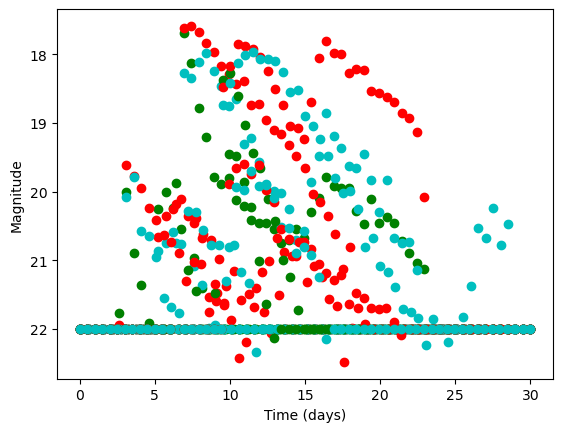

In [33]:
# plot a small sample of the varied light curves

for i in range(0, 300, 50):
    plt.scatter(varied_simembed_dict['varied_simembed_data_0'][i]['t'], varied_simembed_dict['varied_simembed_data_0'][i]['ztfg'], color = 'g')
    plt.scatter(varied_simembed_dict['varied_simembed_data_0'][i]['t'], varied_simembed_dict['varied_simembed_data_0'][i]['ztfr'], color = 'r')
    plt.scatter(varied_simembed_dict['varied_simembed_data_0'][i]['t'], varied_simembed_dict['varied_simembed_data_0'][i]['ztfi'], color = 'c')
plt.gca().invert_yaxis()
plt.xlabel('Time (days)')
plt.ylabel('Magnitude')

In [34]:
# injection files for the additional data

inj_path_simembed = '/nobackup/users/mmdesai/final_injections'
varied_injections = {}

for i in range(0, 10):
    varied_inj_df = pd.DataFrame()
    varied_params = open_json('/injection_simembed_varied_{}.json'.format(i), inj_path_simembed)
    varied_inj_df['mej'] = varied_params['injections']['content']['log10_mej']
    varied_inj_df['vej'] = varied_params['injections']['content']['log10_vej']
    varied_inj_df['xlan'] = varied_params['injections']['content']['log10_Xlan']
    varied_inj_df['shift'] = varied_params['injections']['content']['timeshift']
    varied_inj_df['distance'] = varied_params['injections']['content']['luminosity_distance']
    varied_inj_df['sim_id'] = varied_params['injections']['content']['simulation_id']
    varied_injections['varied_inj_df{}'.format(i)] = varied_inj_df

In [35]:
varied_injections['varied_inj_df0']

,mej,vej,xlan,shift,distance,sim_id
0,-1.818587,-0.599667,-7.510267,2.613751,163.799718,0
1,-1.818587,-0.599667,-7.510267,-1.817151,110.886833,1
2,-1.818587,-0.599667,-7.510267,1.303732,175.215863,2
3,-1.818587,-0.599667,-7.510267,0.564614,113.870816,3
4,-1.818587,-0.599667,-7.510267,-0.656993,54.314649,4
...,...,...,...,...,...,...
24995,-1.404781,-1.260736,-4.222338,5.215099,97.169433,24995
24996,-1.404781,-1.260736,-4.222338,2.957984,161.724000,24996
24997,-1.404781,-1.260736,-4.222338,1.880204,104.611259,24997
24998,-1.404781,-1.260736,-4.222338,1.861048,120.969431,24998


In [36]:
# concatenate dataframe lists

all_varied_data_list = [0] * 10

for i in range(0, 10):
    all_varied_data_list[i] = pd.concat(varied_simembed_dict['varied_simembed_data_{}'.format(i)])

In [37]:
# merge with injection parameters

all_varied_datawparams_list = [0] * 10

for i in range(0, 10):
    all_varied_datawparams_list[i] = all_varied_data_list[i].merge(varied_injections['varied_inj_df{}'.format(i)], on = 'sim_id')
    # save as csv file
    all_varied_datawparams_list[i].to_csv('/nobackup/users/mmdesai/final_csv/varied_lowc_{}.csv'.format(i), index = False)

In [38]:
all_varied_datawparams_list[0]

,t,ztfg,ztfr,ztfi,sim_id,num_detections,mej,vej,xlan,shift,distance
0,0.000000,22.0,22.0,22.0,0,10,-1.818587,-0.599667,-7.510267,2.613751,163.799718
1,0.500000,22.0,22.0,22.0,0,10,-1.818587,-0.599667,-7.510267,2.613751,163.799718
2,1.000000,22.0,22.0,22.0,0,10,-1.818587,-0.599667,-7.510267,2.613751,163.799718
3,1.500000,22.0,22.0,22.0,0,10,-1.818587,-0.599667,-7.510267,2.613751,163.799718
4,2.000000,22.0,22.0,22.0,0,10,-1.818587,-0.599667,-7.510267,2.613751,163.799718
...,...,...,...,...,...,...,...,...,...,...,...
1509745,28.122925,22.0,22.0,22.0,24749,10,-1.649311,-0.591174,-7.547281,4.123209,197.556529
1509746,28.500000,22.0,22.0,22.0,24749,10,-1.649311,-0.591174,-7.547281,4.123209,197.556529
1509747,29.000000,22.0,22.0,22.0,24749,10,-1.649311,-0.591174,-7.547281,4.123209,197.556529
1509748,29.500000,22.0,22.0,22.0,24749,10,-1.649311,-0.591174,-7.547281,4.123209,197.556529


### Fixed Data

In [39]:
fixed_simembed_dict = {}

In [40]:
# get the fixed data

sim_path = '/nobackup/users/mmdesai/lowcsimdata'
num_sims = 25000

simembed_num_lc_list = [24900, 25000, 25000, 25000, 25000, 25000, 25000, 24800, 25000, 25000]

for i in range(0, 10):
    # get the names of each file
    file_names = get_names(sim_path, 'fixed', i, simembed_num_lc_list[i])
    # open the files as dataframes
    fixed_simembed_dict['fixed_simembed_data_{}'.format(i)] = json_to_df(file_names, simembed_num_lc_list[i])
    # pad the data
    fixed_simembed_dict['fixed_simembed_data_{}'.format(i)] = pad_all_dfs(fixed_simembed_dict['fixed_simembed_data_{}'.format(i)])

100%|██████████| 25000/25000 [01:49<00:00, 229.34it/s]


In [41]:
fixed_simembed_dict['fixed_simembed_data_0'][-1]

,t,ztfg,ztfr,ztfi,sim_id,num_detections
0,0.000000,22.0,22.0,22.0,24899,80
1,0.500000,22.0,22.0,22.0,24899,80
2,1.000000,22.0,22.0,22.0,24899,80
3,1.999715,22.0,22.0,22.0,24899,80
4,2.499715,22.0,22.0,22.0,24899,80
...,...,...,...,...,...,...
56,28.000000,22.0,22.0,22.0,24899,80
57,28.500000,22.0,22.0,22.0,24899,80
58,29.000000,22.0,22.0,22.0,24899,80
59,29.500000,22.0,22.0,22.0,24899,80


Text(0, 0.5, 'Magnitude')

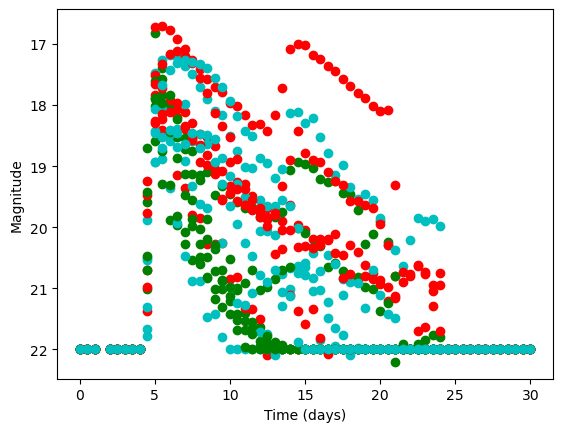

In [42]:
for i in range(0, 300, 50):
    plt.scatter(fixed_simembed_dict['fixed_simembed_data_0'][i]['t'], fixed_simembed_dict['fixed_simembed_data_0'][i]['ztfg'], color = 'g')
    plt.scatter(fixed_simembed_dict['fixed_simembed_data_0'][i]['t'], fixed_simembed_dict['fixed_simembed_data_0'][i]['ztfr'], color = 'r')
    plt.scatter(fixed_simembed_dict['fixed_simembed_data_0'][i]['t'], fixed_simembed_dict['fixed_simembed_data_0'][i]['ztfi'], color = 'c')
plt.gca().invert_yaxis()
plt.xlabel('Time (days)')
plt.ylabel('Magnitude')

In [43]:
# injection files

inj_path_simembed = '/nobackup/users/mmdesai/final_injections'
fixed_injections = {}

for i in range(0, 10):
    fixed_inj_df = pd.DataFrame()
    fixed_params = open_json('/injection_simembed_fixed_{}.json'.format(i), inj_path_simembed)
    fixed_inj_df['mej'] = fixed_params['injections']['content']['log10_mej']
    fixed_inj_df['vej'] = fixed_params['injections']['content']['log10_vej']
    fixed_inj_df['xlan'] = fixed_params['injections']['content']['log10_Xlan']
    fixed_inj_df['shift'] = fixed_params['injections']['content']['timeshift']
    fixed_inj_df['distance'] = fixed_params['injections']['content']['luminosity_distance']
    fixed_inj_df['sim_id'] = fixed_params['injections']['content']['simulation_id']
    fixed_injections['fixed_inj_df{}'.format(i)] = fixed_inj_df

In [44]:
fixed_injections['fixed_inj_df0']

,mej,vej,xlan,shift,distance,sim_id
0,-1.818587,-0.599667,-7.510267,0.0,50.0,0
1,-1.818587,-0.599667,-7.510267,0.0,50.0,1
2,-1.818587,-0.599667,-7.510267,0.0,50.0,2
3,-1.818587,-0.599667,-7.510267,0.0,50.0,3
4,-1.818587,-0.599667,-7.510267,0.0,50.0,4
...,...,...,...,...,...,...
24995,-1.404781,-1.260736,-4.222338,0.0,50.0,24995
24996,-1.404781,-1.260736,-4.222338,0.0,50.0,24996
24997,-1.404781,-1.260736,-4.222338,0.0,50.0,24997
24998,-1.404781,-1.260736,-4.222338,0.0,50.0,24998


In [45]:
# concatenate dataframe lists

all_fixed_data_list = [0] * 10

for i in range(0, 10):
    all_fixed_data_list[i] = pd.concat(fixed_simembed_dict['fixed_simembed_data_{}'.format(i)])

In [46]:
# merge with injection parameters

all_fixed_datawparams_list = [0] * 10

for i in range(0, 10):
    all_fixed_datawparams_list[i] = all_fixed_data_list[i].merge(fixed_injections['fixed_inj_df{}'.format(i)], on = 'sim_id')
    # save as csv file
    all_fixed_datawparams_list[i].to_csv('/nobackup/users/mmdesai/final_csv/fixed_lowc_{}.csv'.format(i), index = False)

In [47]:
all_fixed_datawparams_list[0]

,t,ztfg,ztfr,ztfi,sim_id,num_detections,mej,vej,xlan,shift,distance
0,0.000000,22.0,22.0,22.0,0,45,-1.818587,-0.599667,-7.510267,0.0,50.0
1,0.500000,22.0,22.0,22.0,0,45,-1.818587,-0.599667,-7.510267,0.0,50.0
2,1.000000,22.0,22.0,22.0,0,45,-1.818587,-0.599667,-7.510267,0.0,50.0
3,1.999715,22.0,22.0,22.0,0,45,-1.818587,-0.599667,-7.510267,0.0,50.0
4,2.499715,22.0,22.0,22.0,0,45,-1.818587,-0.599667,-7.510267,0.0,50.0
...,...,...,...,...,...,...,...,...,...,...,...
1518895,28.000000,22.0,22.0,22.0,24899,80,-1.700760,-0.759210,-7.544044,0.0,50.0
1518896,28.500000,22.0,22.0,22.0,24899,80,-1.700760,-0.759210,-7.544044,0.0,50.0
1518897,29.000000,22.0,22.0,22.0,24899,80,-1.700760,-0.759210,-7.544044,0.0,50.0
1518898,29.500000,22.0,22.0,22.0,24899,80,-1.700760,-0.759210,-7.544044,0.0,50.0


# Load in Data

If the data is stored as a .csv file, use this section to further process the data and import it to the notebook. This section ensures that the fixed (unshifted) and shifted light curves are properly paired and assigns each light curve a unique simulation id (sim_id). Batch numbers are also added, with 50 light curves in a batch. Each set of 50 light curves have the same mass, velocity, and lanthanide fraction of the ejecta. The fixed ones peak at the same time and are set to a luminosity distance of 50 Mpc, while the 50 repeated shifted light curves have a time and distance generated from a uniform prior. We also set the condition for number of detections in this section.

In [8]:
# directory where the csv files are stored

data_dir = '/nobackup/users/mmdesai/final_csv/'

In [14]:
# set the minimum number of detections needed

min_num_detections = 8

## First Batch

In [9]:
matched_df1 = matched(data_dir, 'varied', 'fixed', 0, 10) 

In [ ]:
add_batch_sim_nums_all(matched_df1)
matched_df1

In [127]:
true_list1 = []
for i in range(int(len(matched_df1)/num_points/50)):
    batch_df = matched_df1.loc[matched_df1['batch_id'] == i]
    if batch_df['num_detections_x'].min() >= min_num_detections:
        true_list1.append(batch_df)
    else:
        pass

In [128]:
detected_df1 = pd.concat(true_list1)
detected_df1

,t_x,key_1,ztfg_x,ztfr_x,ztfi_x,sim_id,num_detections_x,mej_x,vej_x,xlan_x,...,ztfg_y,ztfr_y,ztfi_y,num_detections_y,mej_y,vej_y,xlan_y,shift_y,distance_y,batch_id
6050,0.00,0,22.0,22.0,22.0,50,76,-1.478878,-1.284697,-7.070885,...,22.0,22.0,22.0,175,-1.478878,-1.284697,-7.070885,0.0,50.0,1
6051,0.25,1,22.0,22.0,22.0,50,76,-1.478878,-1.284697,-7.070885,...,22.0,22.0,22.0,175,-1.478878,-1.284697,-7.070885,0.0,50.0,1
6052,0.50,2,22.0,22.0,22.0,50,76,-1.478878,-1.284697,-7.070885,...,22.0,22.0,22.0,175,-1.478878,-1.284697,-7.070885,0.0,50.0,1
6053,0.75,3,22.0,22.0,22.0,50,76,-1.478878,-1.284697,-7.070885,...,22.0,22.0,22.0,175,-1.478878,-1.284697,-7.070885,0.0,50.0,1
6054,1.00,4,22.0,22.0,22.0,50,76,-1.478878,-1.284697,-7.070885,...,22.0,22.0,22.0,175,-1.478878,-1.284697,-7.070885,0.0,50.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3024995,29.00,116,22.0,22.0,22.0,249249,73,-1.791062,-1.209393,-8.961192,...,22.0,22.0,22.0,128,-1.791062,-1.209393,-8.961192,0.0,50.0,4984
3024996,29.25,117,22.0,22.0,22.0,249249,73,-1.791062,-1.209393,-8.961192,...,22.0,22.0,22.0,128,-1.791062,-1.209393,-8.961192,0.0,50.0,4984
3024997,29.50,118,22.0,22.0,22.0,249249,73,-1.791062,-1.209393,-8.961192,...,22.0,22.0,22.0,128,-1.791062,-1.209393,-8.961192,0.0,50.0,4984
3024998,29.75,119,22.0,22.0,22.0,249249,73,-1.791062,-1.209393,-8.961192,...,22.0,22.0,22.0,128,-1.791062,-1.209393,-8.961192,0.0,50.0,4984


In [129]:
# varied

var_df = detected_df1.iloc[:, :12]
var_df.columns = var_df.columns.str.rstrip('_x')
var_df = var_df.drop(columns=['key_1'])
add_batch_sim_nums_all(var_df)
var_df

,t,ztfg,ztfr,ztfi,sim_id,num_detections,mej,vej,xlan,shift,distance,batch_id
6050,0.00,22.0,22.0,22.0,0,76,-1.478878,-1.284697,-7.070885,0.24486,137.367339,0
6051,0.25,22.0,22.0,22.0,0,76,-1.478878,-1.284697,-7.070885,0.24486,137.367339,0
6052,0.50,22.0,22.0,22.0,0,76,-1.478878,-1.284697,-7.070885,0.24486,137.367339,0
6053,0.75,22.0,22.0,22.0,0,76,-1.478878,-1.284697,-7.070885,0.24486,137.367339,0
6054,1.00,22.0,22.0,22.0,0,76,-1.478878,-1.284697,-7.070885,0.24486,137.367339,0
...,...,...,...,...,...,...,...,...,...,...,...,...
3024995,29.00,22.0,22.0,22.0,210399,73,-1.791062,-1.209393,-8.961192,0.88832,77.786962,4207
3024996,29.25,22.0,22.0,22.0,210399,73,-1.791062,-1.209393,-8.961192,0.88832,77.786962,4207
3024997,29.50,22.0,22.0,22.0,210399,73,-1.791062,-1.209393,-8.961192,0.88832,77.786962,4207
3024998,29.75,22.0,22.0,22.0,210399,73,-1.791062,-1.209393,-8.961192,0.88832,77.786962,4207


In [130]:
# fixed

fix_df = detected_df1.iloc[:, 12:]
fix_df.columns = fix_df.columns.str.rstrip('_y')
add_batch_sim_nums_all(fix_df)
fix_df

,t,ztfg,ztfr,ztfi,num_detections,mej,vej,xlan,shift,distance,batch_id,sim_id
6050,0.00,22.0,22.0,22.0,175,-1.478878,-1.284697,-7.070885,0.0,50.0,0,0
6051,0.25,22.0,22.0,22.0,175,-1.478878,-1.284697,-7.070885,0.0,50.0,0,0
6052,0.50,22.0,22.0,22.0,175,-1.478878,-1.284697,-7.070885,0.0,50.0,0,0
6053,0.75,22.0,22.0,22.0,175,-1.478878,-1.284697,-7.070885,0.0,50.0,0,0
6054,1.00,22.0,22.0,22.0,175,-1.478878,-1.284697,-7.070885,0.0,50.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
3024995,29.00,22.0,22.0,22.0,128,-1.791062,-1.209393,-8.961192,0.0,50.0,4207,210399
3024996,29.25,22.0,22.0,22.0,128,-1.791062,-1.209393,-8.961192,0.0,50.0,4207,210399
3024997,29.50,22.0,22.0,22.0,128,-1.791062,-1.209393,-8.961192,0.0,50.0,4207,210399
3024998,29.75,22.0,22.0,22.0,128,-1.791062,-1.209393,-8.961192,0.0,50.0,4207,210399


## Second Batch

In [15]:
matched_df2 = matched(data_dir, 'varied', 'fixed', 10, 20) 

In [74]:
add_batch_sim_nums_all(matched_df2)
new_df2

,t_x,key_1,ztfg_x,ztfr_x,ztfi_x,sim_id,num_detections_x,mej_x,vej_x,xlan_x,...,ztfg_y,ztfr_y,ztfi_y,num_detections_y,mej_y,vej_y,xlan_y,shift_y,distance_y,batch_id
0,0.00,0,22.0,22.0,22.0,0,128,-1.069935,-1.463916,-4.193444,...,22.0,22.0,22.0,171,-1.069935,-1.463916,-4.193444,0.0,50.0,0
1,0.25,1,22.0,22.0,22.0,0,128,-1.069935,-1.463916,-4.193444,...,22.0,22.0,22.0,171,-1.069935,-1.463916,-4.193444,0.0,50.0,0
2,0.50,2,22.0,22.0,22.0,0,128,-1.069935,-1.463916,-4.193444,...,22.0,22.0,22.0,171,-1.069935,-1.463916,-4.193444,0.0,50.0,0
3,0.75,3,22.0,22.0,22.0,0,128,-1.069935,-1.463916,-4.193444,...,22.0,22.0,22.0,171,-1.069935,-1.463916,-4.193444,0.0,50.0,0
4,1.00,4,22.0,22.0,22.0,0,128,-1.069935,-1.463916,-4.193444,...,22.0,22.0,22.0,171,-1.069935,-1.463916,-4.193444,0.0,50.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3024995,29.00,116,22.0,22.0,22.0,220299,200,-1.086064,-1.054739,-6.334769,...,22.0,22.0,22.0,237,-1.086064,-1.054739,-6.334769,0.0,50.0,4405
3024996,29.25,117,22.0,22.0,22.0,220299,200,-1.086064,-1.054739,-6.334769,...,22.0,22.0,22.0,237,-1.086064,-1.054739,-6.334769,0.0,50.0,4405
3024997,29.50,118,22.0,22.0,22.0,220299,200,-1.086064,-1.054739,-6.334769,...,22.0,22.0,22.0,237,-1.086064,-1.054739,-6.334769,0.0,50.0,4405
3024998,29.75,119,22.0,22.0,22.0,220299,200,-1.086064,-1.054739,-6.334769,...,22.0,22.0,22.0,237,-1.086064,-1.054739,-6.334769,0.0,50.0,4405


In [75]:
true_list2 = []
for i in range(int(len(matched_df2)/121/50)):
    batch_df = matched_df2.loc[matched_df2['batch_id'] == i]
    if batch_df['num_detections_x'].min() >= min_num_detections:
        true_list2.append(batch_df)
    else:
        pass

In [76]:
detected_df2 = pd.concat(true_list2)
detected_df2

,t_x,key_1,ztfg_x,ztfr_x,ztfi_x,sim_id,num_detections_x,mej_x,vej_x,xlan_x,...,ztfg_y,ztfr_y,ztfi_y,num_detections_y,mej_y,vej_y,xlan_y,shift_y,distance_y,batch_id
0,0.00,0,22.0,22.0,22.0,0,128,-1.069935,-1.463916,-4.193444,...,22.0,22.0,22.0,171,-1.069935,-1.463916,-4.193444,0.0,50.0,0
1,0.25,1,22.0,22.0,22.0,0,128,-1.069935,-1.463916,-4.193444,...,22.0,22.0,22.0,171,-1.069935,-1.463916,-4.193444,0.0,50.0,0
2,0.50,2,22.0,22.0,22.0,0,128,-1.069935,-1.463916,-4.193444,...,22.0,22.0,22.0,171,-1.069935,-1.463916,-4.193444,0.0,50.0,0
3,0.75,3,22.0,22.0,22.0,0,128,-1.069935,-1.463916,-4.193444,...,22.0,22.0,22.0,171,-1.069935,-1.463916,-4.193444,0.0,50.0,0
4,1.00,4,22.0,22.0,22.0,0,128,-1.069935,-1.463916,-4.193444,...,22.0,22.0,22.0,171,-1.069935,-1.463916,-4.193444,0.0,50.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3024995,29.00,116,22.0,22.0,22.0,220299,200,-1.086064,-1.054739,-6.334769,...,22.0,22.0,22.0,237,-1.086064,-1.054739,-6.334769,0.0,50.0,4405
3024996,29.25,117,22.0,22.0,22.0,220299,200,-1.086064,-1.054739,-6.334769,...,22.0,22.0,22.0,237,-1.086064,-1.054739,-6.334769,0.0,50.0,4405
3024997,29.50,118,22.0,22.0,22.0,220299,200,-1.086064,-1.054739,-6.334769,...,22.0,22.0,22.0,237,-1.086064,-1.054739,-6.334769,0.0,50.0,4405
3024998,29.75,119,22.0,22.0,22.0,220299,200,-1.086064,-1.054739,-6.334769,...,22.0,22.0,22.0,237,-1.086064,-1.054739,-6.334769,0.0,50.0,4405


In [77]:
# varied

var_df = detected_df2.iloc[:, :12]
var_df.columns = var_df.columns.str.rstrip('_x')
var_df = var_df.drop(columns=['key_1'])
add_batch_sim_nums_all(var_df)
var_df

,t,ztfg,ztfr,ztfi,sim_id,num_detections,mej,vej,xlan,shift,distance,batch_id
0,0.00,22.0,22.0,22.0,0,128,-1.069935,-1.463916,-4.193444,-0.209267,92.872609,0
1,0.25,22.0,22.0,22.0,0,128,-1.069935,-1.463916,-4.193444,-0.209267,92.872609,0
2,0.50,22.0,22.0,22.0,0,128,-1.069935,-1.463916,-4.193444,-0.209267,92.872609,0
3,0.75,22.0,22.0,22.0,0,128,-1.069935,-1.463916,-4.193444,-0.209267,92.872609,0
4,1.00,22.0,22.0,22.0,0,128,-1.069935,-1.463916,-4.193444,-0.209267,92.872609,0
...,...,...,...,...,...,...,...,...,...,...,...,...
3024995,29.00,22.0,22.0,22.0,219849,200,-1.086064,-1.054739,-6.334769,2.651275,72.080275,4396
3024996,29.25,22.0,22.0,22.0,219849,200,-1.086064,-1.054739,-6.334769,2.651275,72.080275,4396
3024997,29.50,22.0,22.0,22.0,219849,200,-1.086064,-1.054739,-6.334769,2.651275,72.080275,4396
3024998,29.75,22.0,22.0,22.0,219849,200,-1.086064,-1.054739,-6.334769,2.651275,72.080275,4396


In [78]:
# fixed

fix_df = detected_df2.iloc[:, 12:]
fix_df.columns = fix_df.columns.str.rstrip('_y')
add_batch_sim_nums_all(fix_df)
fix_df

,t,ztfg,ztfr,ztfi,num_detections,mej,vej,xlan,shift,distance,batch_id,sim_id
0,0.00,22.0,22.0,22.0,171,-1.069935,-1.463916,-4.193444,0.0,50.0,0,0
1,0.25,22.0,22.0,22.0,171,-1.069935,-1.463916,-4.193444,0.0,50.0,0,0
2,0.50,22.0,22.0,22.0,171,-1.069935,-1.463916,-4.193444,0.0,50.0,0,0
3,0.75,22.0,22.0,22.0,171,-1.069935,-1.463916,-4.193444,0.0,50.0,0,0
4,1.00,22.0,22.0,22.0,171,-1.069935,-1.463916,-4.193444,0.0,50.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
3024995,29.00,22.0,22.0,22.0,237,-1.086064,-1.054739,-6.334769,0.0,50.0,4396,219849
3024996,29.25,22.0,22.0,22.0,237,-1.086064,-1.054739,-6.334769,0.0,50.0,4396,219849
3024997,29.50,22.0,22.0,22.0,237,-1.086064,-1.054739,-6.334769,0.0,50.0,4396,219849
3024998,29.75,22.0,22.0,22.0,237,-1.086064,-1.054739,-6.334769,0.0,50.0,4396,219849


# Tensor Processing

In [14]:
# moving the data to tensors on gpu -- ONLY RUN IF YOU ARE USING DATA FROM A CSV FILE

# num_batches_paper_sample = len(var_df['batch_id'].unique())
# data_shifted_paper, data_unshifted_paper, param_shifted_paper, param_unshifted_paper = repeated_df_to_tensor(
#     var_df, fix_df, num_batches_paper_sample)

In [15]:
# call the path to the tensors from Zenodo and load the data in

data_shifted_paper1 = torch.load('/nobackup/users/mmdesai/updated_tensors/data_shifted_paper4.pt')
data_unshifted_paper1 = torch.load('/nobackup/users/mmdesai/updated_tensors/data_unshifted_paper4.pt')
param_shifted_paper1 = torch.load('/nobackup/users/mmdesai/updated_tensors/param_shifted_paper4.pt')
param_unshifted_paper1 = torch.load('/nobackup/users/mmdesai/updated_tensors/param_unshifted_paper4.pt')

In [16]:
data_shifted_paper2 = torch.load('/nobackup/users/mmdesai/updated_tensors/data_shifted_paper5.pt')
data_unshifted_paper2 = torch.load('/nobackup/users/mmdesai/updated_tensors/data_unshifted_paper5.pt')
param_shifted_paper2 = torch.load('/nobackup/users/mmdesai/updated_tensors/param_shifted_paper5.pt')
param_unshifted_paper2 = torch.load('/nobackup/users/mmdesai/updated_tensors/param_unshifted_paper5.pt')

In [17]:
data_shifted_paper = torch.stack(data_shifted_paper1 + data_shifted_paper2)
data_unshifted_paper = torch.stack(data_unshifted_paper1 + data_unshifted_paper2)
param_shifted_paper = torch.stack(param_shifted_paper1 + param_shifted_paper2)
param_unshifted_paper = torch.stack(param_unshifted_paper1 + param_unshifted_paper2)

In [18]:
# the data is organized into number of repeats (50) x number of channels (3 - ztfg, ztfr, ztfi) x number of points (121)

data_shifted_paper[0].shape

torch.Size([50, 3, 121])

In [19]:
# the parameters stored are in the order: mass, velocity, lanthanide fraction, time, and distance

param_shifted_paper[0].shape

torch.Size([50, 1, 5])

In [20]:
# total number of batches, each batch contains 50 light curves

num_batches_paper_sample = len(data_shifted_paper)
print(num_batches_paper_sample)

8729


# Similarity Embedding Dataset

In [21]:
# define the loss
vicreg_loss = VICRegLoss()

In [22]:
# define the dataset

dataset_paper = Paper_data(data_shifted_paper, data_unshifted_paper, param_shifted_paper, param_unshifted_paper, num_batches_paper_sample)

# check the dataset shape
_, t, d, _ = dataset_paper[4]
_.shape, t.shape, d.shape

(torch.Size([50, 3, 121]), torch.Size([50, 1, 5]), torch.Size([50, 3, 121]))

In [23]:
# split dataset into training, testing, and validation

num_batches_paper_sample = len(data_shifted_paper)

train_set_size_paper = int(0.8 * num_batches_paper_sample)    
val_set_size_paper = int(0.1 * num_batches_paper_sample)     
test_set_size_paper = num_batches_paper_sample - train_set_size_paper - val_set_size_paper

train_data_paper, val_data_paper, test_data_paper = torch.utils.data.random_split(
    dataset_paper, [train_set_size_paper, val_set_size_paper, test_set_size_paper])

In [24]:
# load and shuffle the data

train_data_loader_paper = DataLoader(train_data_paper, batch_size=50, shuffle=True)
val_data_loader_paper = DataLoader(val_data_paper, batch_size=50, shuffle=True)
test_data_loader_paper = DataLoader(test_data_paper, batch_size=1, shuffle=False)

# check lengths
len(train_data_loader_paper), len(test_data_loader_paper), len(val_data_loader_paper)

(140, 874, 18)

# Data Visualization

Taking a look at some of the data distributions

## Histograms

Checking if the selected data still is uniform after selecting data with greater than 8 detections

In [25]:
mej_list = []
vej_list = []
xlan_list = []

for i in range(len(param_shifted_paper)):
    mej = param_shifted_paper[i][0][0][0]
    vej = param_shifted_paper[i][0][0][1]
    xlan = param_shifted_paper[i][0][0][2]
    mej_list.append(mej)
    vej_list.append(vej)
    xlan_list.append(xlan)

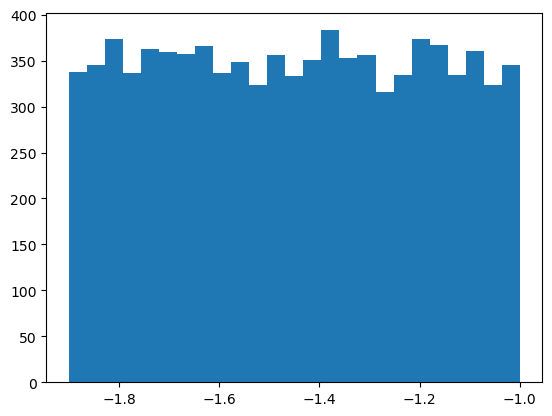

In [26]:
hist = plt.hist(mej_list, bins=25)

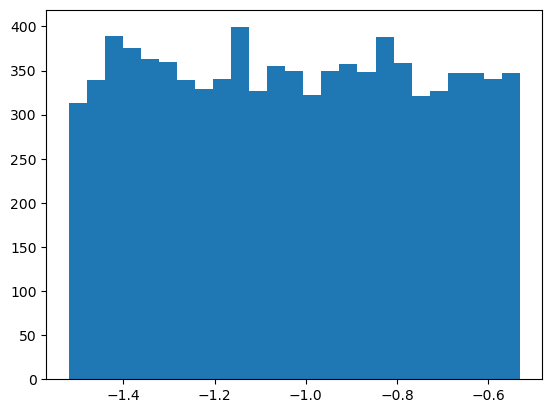

In [27]:
hist = plt.hist(vej_list, bins=25)

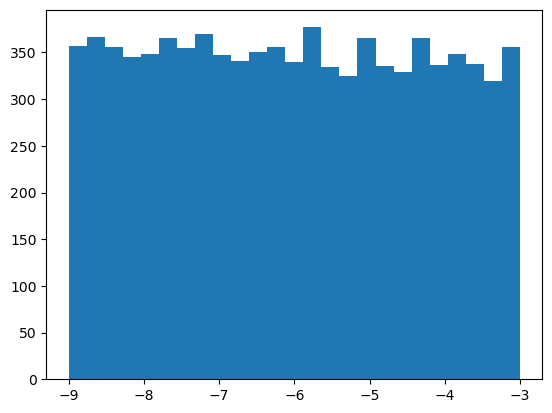

In [28]:
ist = plt.hist(xlan_list, bins=25)

In [29]:
dist_list = []
shift_list = []

for i in range(len(param_shifted_paper)):
    for j in range(0, 50):
        dist = param_shifted_paper[i][j][0][4]
        shift = param_shifted_paper[i][j][0][3]
        dist_list.append(dist)
        shift_list.append(shift)

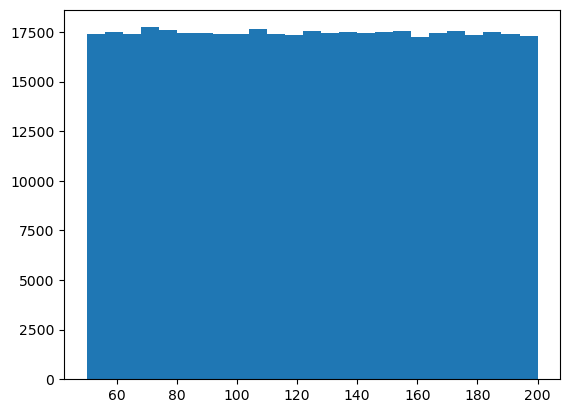

In [30]:
hist = plt.hist(dist_list, bins = 25)

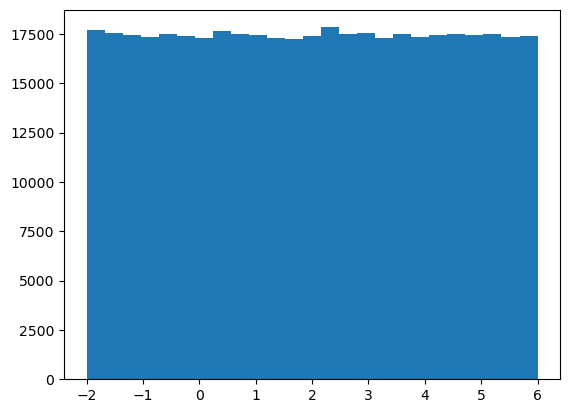

In [31]:
hist = plt.hist(shift_list, bins=25)

## Light Curve Graphs

Some plotting codes for visualizing the light curves from the .csv files -- SKIP FOR NOW

In [32]:

fixed_colors = ['seagreen', 'crimson', 'blue']
varied_colors = ['mediumaquamarine', 'salmon', 'skyblue']
label_list = ['g band', 'r band', 'i band']

def varied_fixed_plot(varied_df, fixed_df, sim_id, xlim_min=None, xlim_max=None, title = False, bands=bands):
    varied_data = varied_df.loc[varied_df['sim_id'] == sim_id]
    fixed_data = fixed_df.loc[fixed_df['sim_id'] == sim_id]
    if 'mej' in varied_data.columns:
        mej = varied_data.iloc[0, varied_data.columns.get_loc('mej')]
    if 'vej' in varied_data.columns:
        vej = varied_data.iloc[0, varied_data.columns.get_loc('vej')]
    if 'xlan' in varied_data.columns:
        xlan = varied_data.iloc[0, varied_data.columns.get_loc('xlan')]
    fig, axs = plt.subplots(3, sharex=True, sharey=True, figsize=(7,7))
    for i in range(len(bands)):
        axs[i].scatter(fixed_data['t'], fixed_data[bands[i]], label = 'fixed, ' + label_list[i] , color = fixed_colors[i], s = 10)
        axs[i].scatter(varied_data['t'], varied_data[bands[i]], label = 'shifted, ' + label_list[i], color = varied_colors[i], s = 10)
        plt.gca().invert_yaxis()
        axs[i].legend()
        if (xlim_min != None) & (xlim_max != None):
            plt.xlim(xlim_min, xlim_max)
    fig.supxlabel('Time (Days)')
    fig.supylabel('Magnitude')
    if title == True:
        if ('vej' in varied_data.columns) and ('mej' in varied_data.columns):
            fig.suptitle('Light Curve for $\log_{{10}}(M_{{ej}})$: {:.2f}, $\log_{{10}}(V_{{ej}})$: {:.2f}, \n$\log_{{10}}(X_{{lan}})$: {:.2f}'.format(mej, vej, xlan), 
                         fontsize = 15)
    else:
        pass
    if 'shift' in varied_data.columns:
        shift = varied_data.iloc[0, varied_data.columns.get_loc('shift')]
    if 'distance' in varied_data.columns:
        distance = varied_data.iloc[0, varied_data.columns.get_loc('distance')]
    print(shift, distance)
    plt.show()

1.3037319437332575 175.21586341377756


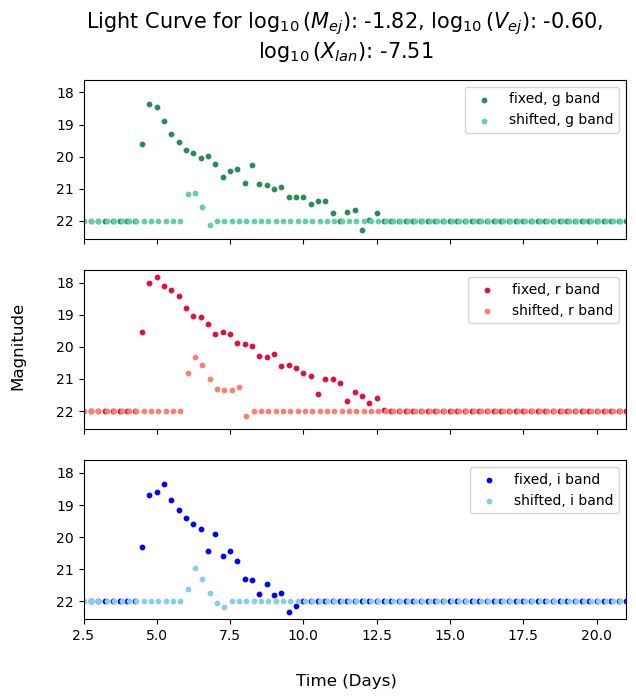

In [51]:
varied_fixed_plot(var_df, fix_df, 2, 2.5, 21, title = True)

# Similarity Embedding

In [32]:
# puts the neural network on the gpu
similarity_embedding = SimilarityEmbedding(num_dim=7, num_hidden_layers_f=1, num_hidden_layers_h=1, num_blocks=4, kernel_size=5, num_dim_final=5).to(device)
num_dim = 7

# optimizes
optimizer = optim.Adam(similarity_embedding.parameters(), lr=2.747064325271709e-05)

# sets learning rate steps
scheduler_1 = optim.lr_scheduler.ConstantLR(optimizer, total_iters=5) #constant lr
scheduler_2 = optim.lr_scheduler.OneCycleLR(optimizer, total_steps=20, max_lr=2e-3) #one cycle - increase and then decrease
scheduler_3 = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)
scheduler = optim.lr_scheduler.SequentialLR(optimizer, schedulers=[scheduler_1, scheduler_2, scheduler_3], milestones=[5, 15])

In [33]:
# check if data is the right shape for similarity embedding

for var_inj_se, fix_inj_se, var_data_se, fix_data_se in train_data_loader_paper:
    var_inj_se = var_inj_se.reshape((-1,)+var_inj_se.shape[2:])
    fix_inj_se = fix_inj_se.reshape((-1,)+fix_inj_se.shape[2:])
    var_data_se = var_data_se.reshape((-1,)+var_data_se.shape[2:])
    fix_data_se = fix_data_se.reshape((-1,)+fix_data_se.shape[2:])
    break
var_inj_se.shape, var_data_se.shape, fix_inj_se.shape, fix_data_se.shape

(torch.Size([2500, 1, 5]),
 torch.Size([2500, 3, 121]),
 torch.Size([2500, 1, 5]),
 torch.Size([2500, 3, 121]))

In [34]:
# checking the shapes

embed, rep = similarity_embedding(var_data_se)
embed.shape, rep.shape

(torch.Size([2500, 5]), torch.Size([2500, 7]))

In [35]:
# embed the data and calculate the loss for one example to check for bugs

emb_aug, rep_aug = similarity_embedding(var_data_se)
emb_orig, rep_orig = similarity_embedding(fix_data_se)
vicreg_loss(emb_aug, emb_orig)

(tensor(0.9897, device='cuda:0', grad_fn=<AddBackward0>),
 tensor(1.2830e-05, device='cuda:0', grad_fn=<MseLossBackward0>),
 tensor(1.3871e-05, device='cuda:0', grad_fn=<AddBackward0>),
 tensor(0.9897, device='cuda:0', grad_fn=<AddBackward0>))

In [36]:
# print neural network parameters that require gradients and sum parameters

sum_param=0
for name, param in similarity_embedding.named_parameters():
    if param.requires_grad:
        print(name)
        print(param.numel())
        sum_param+=param.numel()
print(sum_param)

layer_norm.weight
363
layer_norm.bias
363
layers_f.conv1.weight
1344
layers_f.bn1.weight
64
layers_f.bn1.bias
64
layers_f.residual_layers.0.0.conv1.weight
20480
layers_f.residual_layers.0.0.bn1.weight
64
layers_f.residual_layers.0.0.bn1.bias
64
layers_f.residual_layers.0.0.conv2.weight
20480
layers_f.residual_layers.0.0.bn2.weight
64
layers_f.residual_layers.0.0.bn2.bias
64
layers_f.residual_layers.0.1.conv1.weight
20480
layers_f.residual_layers.0.1.bn1.weight
64
layers_f.residual_layers.0.1.bn1.bias
64
layers_f.residual_layers.0.1.conv2.weight
20480
layers_f.residual_layers.0.1.bn2.weight
64
layers_f.residual_layers.0.1.bn2.bias
64
layers_f.residual_layers.1.0.conv1.weight
40960
layers_f.residual_layers.1.0.bn1.weight
128
layers_f.residual_layers.1.0.bn1.bias
128
layers_f.residual_layers.1.0.conv2.weight
81920
layers_f.residual_layers.1.0.bn2.weight
128
layers_f.residual_layers.1.0.bn2.bias
128
layers_f.residual_layers.1.0.downsample.0.weight
8192
layers_f.residual_layers.1.0.downsamp

In [37]:
# write to tensorboard for data visualization

writer = SummaryWriter("torchlogs/")
model = similarity_embedding
writer.add_graph(model, var_data_se)
writer.close()

In [38]:
%%time
# training the neural network for many epochs

epoch_number = 0
EPOCHS = 50

sim_val_loss = []
sim_train_loss = []

for epoch in range(EPOCHS):
    print('EPOCH {}:'.format(epoch_number + 1))

    # set the vicreg weights
    wt_repr, wt_cov, wt_std = (1, 1, 1)
    print(f"VicReg wts: {wt_repr} {wt_cov} {wt_std}")
    
    # Gradient tracking
    similarity_embedding.train(True)
    avg_train_loss = train_one_epoch_se(epoch_number, writer, train_data_loader_paper,
                                        similarity_embedding, optimizer, vicreg_loss, verbose=True,
                                        wt_repr=wt_repr, wt_cov=wt_cov, wt_std=wt_std)
    sim_train_loss.append(avg_train_loss)
    
    # no gradient tracking, for validation
    similarity_embedding.train(False)
    similarity_embedding.eval()
    avg_val_loss = val_one_epoch_se(epoch_number, writer, val_data_loader_paper,
                                    similarity_embedding, vicreg_loss,
                                    wt_repr=wt_repr, wt_cov=wt_cov, wt_std=wt_std)
    sim_val_loss.append(avg_val_loss)
    
    print(f"Train/Val Sim Loss after epoch: {avg_train_loss:.4f}/{avg_val_loss:.4f}")

    epoch_number += 1
    scheduler.step()


EPOCH 1:
VicReg wts: 1 1 1
 Avg. train loss/batch after 10 batches = 0.9891
Last 0.00; 0.00; 0.99
 Avg. train loss/batch after 20 batches = 0.9872
Last 0.00; 0.00; 0.98
 Avg. train loss/batch after 30 batches = 0.9846
Last 0.00; 0.00; 0.98
 Avg. train loss/batch after 40 batches = 0.9814
Last 0.00; 0.00; 0.98
 Avg. train loss/batch after 50 batches = 0.9772
Last 0.00; 0.00; 0.97
 Avg. train loss/batch after 60 batches = 0.9721
Last 0.00; 0.00; 0.96
 Avg. train loss/batch after 70 batches = 0.9661
Last 0.00; 0.00; 0.96
 Avg. train loss/batch after 80 batches = 0.9576
Last 0.00; 0.00; 0.94
 Avg. train loss/batch after 90 batches = 0.9493
Last 0.01; 0.00; 0.94
 Avg. train loss/batch after 100 batches = 0.9419
Last 0.01; 0.00; 0.93
 Avg. train loss/batch after 110 batches = 0.9293
Last 0.01; 0.00; 0.91
 Avg. train loss/batch after 120 batches = 0.9184
Last 0.01; 0.00; 0.89
 Avg. train loss/batch after 130 batches = 0.9083
Last 0.02; 0.00; 0.88
 Avg. train loss/batch after 140 batches = 0.8

/home/mmdesai/.conda/envs/my_torch/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


 Avg. train loss/batch after 10 batches = 0.1832
Last 0.05; 0.00; 0.13
 Avg. train loss/batch after 20 batches = 0.1829
Last 0.03; 0.00; 0.10
 Avg. train loss/batch after 30 batches = 0.1607
Last 0.04; 0.00; 0.10
 Avg. train loss/batch after 40 batches = 0.1568
Last 0.05; 0.00; 0.09
 Avg. train loss/batch after 50 batches = 0.1523
Last 0.06; 0.00; 0.09
 Avg. train loss/batch after 60 batches = 0.1540
Last 0.04; 0.00; 0.07
 Avg. train loss/batch after 70 batches = 0.1504
Last 0.04; 0.00; 0.09
 Avg. train loss/batch after 80 batches = 0.1294
Last 0.09; 0.00; 0.07
 Avg. train loss/batch after 90 batches = 0.1223
Last 0.10; 0.00; 0.05
 Avg. train loss/batch after 100 batches = 0.1195
Last 0.05; 0.00; 0.04
 Avg. train loss/batch after 110 batches = 0.0997
Last 0.03; 0.00; 0.03
 Avg. train loss/batch after 120 batches = 0.0806
Last 0.04; 0.00; 0.02
 Avg. train loss/batch after 130 batches = 0.0886
Last 0.05; 0.00; 0.03
 Avg. train loss/batch after 140 batches = 0.0719
Last 0.07; 0.01; 0.04
T

Text(0, 0.5, 'Loss')

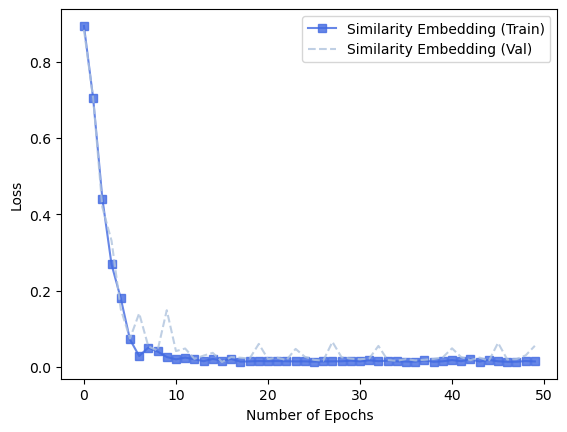

In [39]:
# plot the train/val loss 

epoch_list = range(0,len(sim_train_loss))
plt.plot(epoch_list, sim_train_loss, label = 'Similarity Embedding (Train)', color = 'royalblue', alpha = 0.8, marker = 's')
plt.plot(epoch_list, sim_val_loss, label = 'Similarity Embedding (Val)', color = 'lightsteelblue', alpha=0.8, linestyle="dashed")
plt.legend()
plt.xlabel('Number of Epochs')
plt.ylabel('Loss')

## Saving Embedding Weights

In [40]:
# save the embedded weights (input your save path)

SAVEPATH = '/nobackup/users/mmdesai/similarity-embedding-weights-tutorial.pth'
torch.save(similarity_embedding.state_dict(), SAVEPATH)

# Loading Embedding Weights

If you do not want to retrain the embedding, just load the pretrained weights here: 

In [41]:
# load the weights 

similarity_embedding = SimilarityEmbedding(num_dim=7, num_hidden_layers_f=1, num_hidden_layers_h=1, num_blocks=4, kernel_size=5, num_dim_final=5).to(device)
num_dim = 7

SAVEPATH = '/nobackup/users/mmdesai/similarity-embedding-weights-tutorial.pth'
similarity_embedding.load_state_dict(torch.load(SAVEPATH, map_location=device))

<All keys matched successfully>

# Visualizing the embedding for all test cases

In [42]:
similarity_embedding.train(False)
data_loader = test_data_loader_paper

similarity_outputs_1 = []

for idx, (_, shift_test, data_test, data_test_orig) in enumerate(data_loader):
    _ = _.reshape((-1,)+_.shape[2:])
    data_test = data_test.reshape((-1,)+data_test.shape[2:])
    data_test_orig = data_test_orig.reshape((-1,)+data_test_orig.shape[2:])
    shift_test = shift_test.reshape((-1,)+shift_test.shape[2:])
    if not ((shift_test[0][0][0] < -1) and (shift_test[0][0][0] > -1.25)):
        continue
    if not ((shift_test[0][0][1] < -0.5) and (shift_test[0][0][1] > -0.75)):
        continue
    if not ((shift_test[0][0][2] < -3) and (shift_test[0][0][2] > -4.5)):
        continue
    with torch.no_grad():
        _, similarity_output = similarity_embedding(data_test)
    similarity_outputs_1.append(similarity_output)

similarity_outputs_2 = []

for idx, (_, shift_test, data_test, data_test_orig) in enumerate(data_loader):
    _ = _.reshape((-1,)+_.shape[2:])
    data_test = data_test.reshape((-1,)+data_test.shape[2:])
    data_test_orig = data_test_orig.reshape((-1,)+data_test_orig.shape[2:])
    shift_test = shift_test.reshape((-1,)+shift_test.shape[2:])
    if not ((shift_test[0][0][0] < -1.25) and (shift_test[0][0][0] > -1.5)):
        continue
    if not ((shift_test[0][0][1] < -0.75) and (shift_test[0][0][1] > -1)):
        continue
    if not ((shift_test[0][0][2] < -4.5) and (shift_test[0][0][2] > -6)):
        continue
    with torch.no_grad():
        _, similarity_output = similarity_embedding(data_test)
    similarity_outputs_2.append(similarity_output)

similarity_outputs_3 = []

for idx, (_, shift_test, data_test, data_test_orig) in enumerate(data_loader):
    _ = _.reshape((-1,)+_.shape[2:])
    data_test = data_test.reshape((-1,)+data_test.shape[2:])
    data_test_orig = data_test_orig.reshape((-1,)+data_test_orig.shape[2:])
    shift_test = shift_test.reshape((-1,)+shift_test.shape[2:])
    if not ((shift_test[0][0][0] < -1.5) and (shift_test[0][0][0] > -1.75)):
        continue
    if not ((shift_test[0][0][1] < -1) and (shift_test[0][0][1] > -1.25)):
        continue
    if not ((shift_test[0][0][2] < -6) and (shift_test[0][0][2] > -7.5)):
        continue
    with torch.no_grad():
        _, similarity_output = similarity_embedding(data_test)
    similarity_outputs_3.append(similarity_output)

similarity_outputs_4 = []

for idx, (_, shift_test, data_test, data_test_orig) in enumerate(data_loader):
    _ = _.reshape((-1,)+_.shape[2:])
    data_test = data_test.reshape((-1,)+data_test.shape[2:])
    data_test_orig = data_test_orig.reshape((-1,)+data_test_orig.shape[2:])
    shift_test = shift_test.reshape((-1,)+shift_test.shape[2:])
    if not ((shift_test[0][0][0] < -1.75) and (shift_test[0][0][0] > -2.5)):
        continue
    if not ((shift_test[0][0][1] < -1.25) and (shift_test[0][0][1] > -1.55)):
        continue
    if not ((shift_test[0][0][2] < -7.5) and (shift_test[0][0][2] > -9)):
        continue
    with torch.no_grad():
        _, similarity_output = similarity_embedding(data_test)
    similarity_outputs_4.append(similarity_output)



In [43]:
similarity_outputs_1 = torch.stack(similarity_outputs_1)
similarity_outputs_2 = torch.stack(similarity_outputs_2)
similarity_outputs_3 = torch.stack(similarity_outputs_3)
similarity_outputs_4 = torch.stack(similarity_outputs_4)

In [44]:
similarity_outputs_1.shape, similarity_outputs_2.shape, similarity_outputs_3.shape, similarity_outputs_4.shape

(torch.Size([9, 50, 7]),
 torch.Size([14, 50, 7]),
 torch.Size([13, 50, 7]),
 torch.Size([8, 50, 7]))

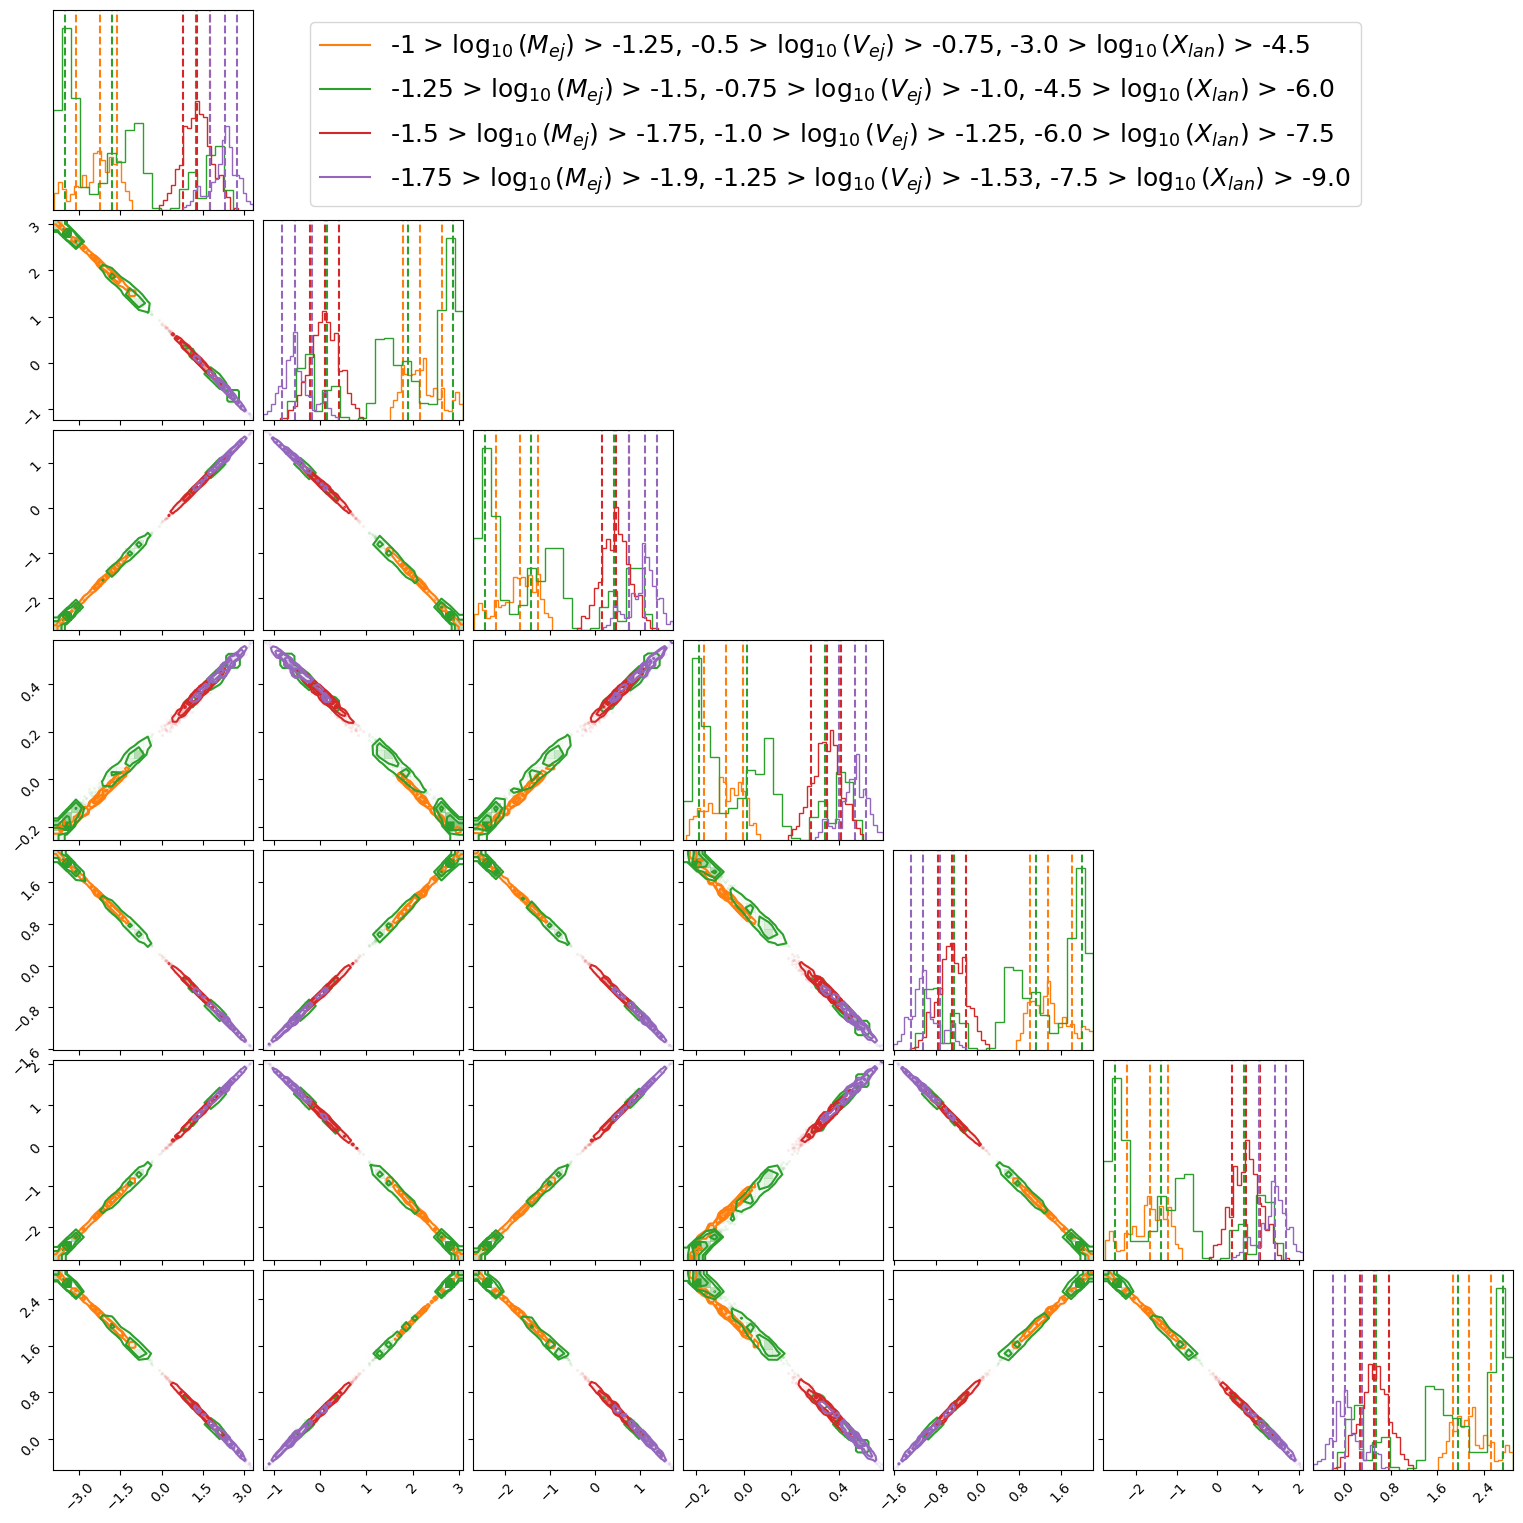

In [45]:
figure = corner.corner(
    similarity_outputs_1.cpu().numpy().reshape((similarity_outputs_1.shape[0]*similarity_outputs_1.shape[1], num_dim)),
    quantiles=[0.16, 0.5, 0.84], color="C1"#, range = [[-1.2,-0.8], [-1.2,-0.8], [-1.2,-0.8]]
)
c1_line = mlines.Line2D([], [], color='C1', 
                            label='-1 > $\log_{{10}}(M_{{ej}})$ > -1.25, -0.5 > $\log_{{10}}(V_{{ej}})$ > -0.75, -3.0 > $\log_{{10}}(X_{{lan}})$ > -4.5')

figure = corner.corner(
    similarity_outputs_2.cpu().numpy().reshape((similarity_outputs_2.shape[0]*similarity_outputs_2.shape[1], num_dim)),
    quantiles=[0.16, 0.5, 0.84], fig=figure, 
    color="C2", # range = [[-1.2,-0.8], [-1.2,-0.8], [-1.2,-0.8]]
)
c2_line = mlines.Line2D([], [], color='C2', 
                            label='-1.25 > $\log_{{10}}(M_{{ej}})$ > -1.5, -0.75 > $\log_{{10}}(V_{{ej}})$ > -1.0, -4.5 > $\log_{{10}}(X_{{lan}})$ > -6.0')

figure = corner.corner(
    similarity_outputs_3.cpu().numpy().reshape((similarity_outputs_3.shape[0]*similarity_outputs_3.shape[1], num_dim)),
    quantiles=[0.16, 0.5, 0.84], fig=figure, color="C3"
)
c3_line = mlines.Line2D([], [], color='C3', 
                            label='-1.5 > $\log_{{10}}(M_{{ej}})$ > -1.75, -1.0 > $\log_{{10}}(V_{{ej}})$ > -1.25, -6.0 > $\log_{{10}}(X_{{lan}})$ > -7.5')

figure = corner.corner(
    similarity_outputs_4.cpu().numpy().reshape((similarity_outputs_4.shape[0]*similarity_outputs_4.shape[1], num_dim)),
    quantiles=[0.16, 0.5, 0.84], fig=figure, color="C4"
)
c4_line = mlines.Line2D([], [], color='C4', 
                            label='-1.75 > $\log_{{10}}(M_{{ej}})$ > -1.9, -1.25 > $\log_{{10}}(V_{{ej}})$ > -1.53, -7.5 > $\log_{{10}}(X_{{lan}})$ > -9.0')

plt.legend(handles=
           [c1_line, c2_line, c3_line, c4_line],
           bbox_to_anchor=(0.3, 7.3),
           fontsize = 18
          )

# Normalizing Flow Training Data

### Varied Data

In [146]:
varied_normflow_dict = {}

In [148]:
# get the varied data

norm_path = '/nobackup/users/mmdesai/lowcflowdata'
num_sims = 25000

normflow_num_lc_list = [25000, 25000, 25000, 24843, 25000, 24917, 25000, 25000, 24706, 25000]

for i in range(3, 10):
    # get the names of each file
    file_names = get_names(norm_path, 'varied', i, normflow_num_lc_list[i])
    # open the files as dataframes
    varied_normflow_dict['varied_normflow_data_{}'.format(i)] = json_to_df(file_names, normflow_num_lc_list[i])
    # pad the data
    varied_normflow_dict['varied_normflow_data_{}'.format(i)] = pad_all_dfs(varied_normflow_dict['varied_normflow_data_{}'.format(i)])

100%|██████████| 25000/25000 [02:03<00:00, 202.71it/s]


In [149]:
varied_normflow_dict['varied_normflow_data_0'][0]

,t,ztfg,ztfr,ztfi,sim_id,num_detections
0,0.000000,22.0,22.0,22.0,0,36
1,0.500000,22.0,22.0,22.0,0,36
2,1.000000,22.0,22.0,22.0,0,36
3,1.500000,22.0,22.0,22.0,0,36
4,2.000000,22.0,22.0,22.0,0,36
...,...,...,...,...,...,...
56,28.005336,22.0,22.0,22.0,0,36
57,28.505336,22.0,22.0,22.0,0,36
58,29.005336,22.0,22.0,22.0,0,36
59,29.500000,22.0,22.0,22.0,0,36


Text(0, 0.5, 'Magnitude')

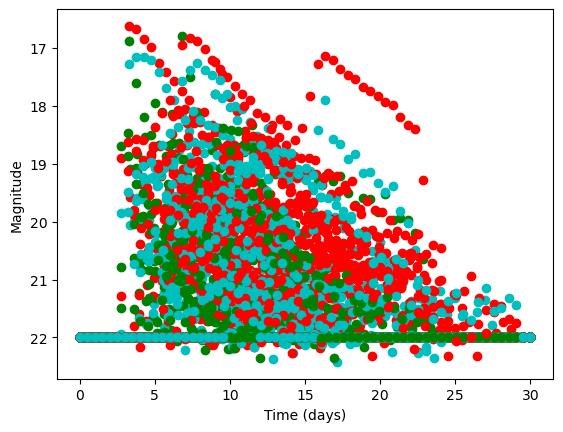

In [150]:
for i in range(0, 50):
    plt.scatter(varied_normflow_dict['varied_normflow_data_0'][i]['t'], varied_normflow_dict['varied_normflow_data_0'][i]['ztfg'], color = 'g')
    plt.scatter(varied_normflow_dict['varied_normflow_data_0'][i]['t'], varied_normflow_dict['varied_normflow_data_0'][i]['ztfr'], color = 'r')
    plt.scatter(varied_normflow_dict['varied_normflow_data_0'][i]['t'], varied_normflow_dict['varied_normflow_data_0'][i]['ztfi'], color = 'c')
plt.gca().invert_yaxis()
plt.xlabel('Time (days)')
plt.ylabel('Magnitude')

In [151]:
# injection files

varied_normflow_inj_dict = {}
inj_path_normflow = '/nobackup/users/mmdesai/final_injections/'

for i in range(0, 10):
    varied_normflow_inj_dict['varied_inj_df{}'.format(i)] = pd.DataFrame()
    varied_params = open_json('injection_normflow_varied_{}.json'.format(i), inj_path_normflow)
    varied_normflow_inj_dict['varied_inj_df{}'.format(i)]['mej'] = varied_params['injections']['content']['log10_mej']
    varied_normflow_inj_dict['varied_inj_df{}'.format(i)]['vej'] = varied_params['injections']['content']['log10_vej']
    varied_normflow_inj_dict['varied_inj_df{}'.format(i)]['xlan'] = varied_params['injections']['content']['log10_Xlan']
    varied_normflow_inj_dict['varied_inj_df{}'.format(i)]['shift'] = varied_params['injections']['content']['timeshift']
    varied_normflow_inj_dict['varied_inj_df{}'.format(i)]['distance'] = varied_params['injections']['content']['luminosity_distance']
    varied_normflow_inj_dict['varied_inj_df{}'.format(i)]['sim_id'] = varied_params['injections']['content']['simulation_id']

In [152]:
varied_normflow_inj_dict['varied_inj_df0']

,mej,vej,xlan,shift,distance,sim_id
0,-1.699903,-0.666101,-4.001011,5.005620,67.635881,0
1,-1.391521,-1.517531,-7.368679,-1.017165,193.390863,1
2,-1.032932,-0.714263,-7.778590,-1.716948,58.173352,2
3,-1.882715,-0.696605,-6.322453,5.001262,95.072802,3
4,-1.266499,-0.718221,-8.777922,-0.555267,133.838756,4
...,...,...,...,...,...,...
24995,-1.027906,-0.686140,-4.713936,3.724953,103.111823,24995
24996,-1.846842,-0.616111,-5.397569,3.258134,84.560098,24996
24997,-1.844926,-0.558436,-8.790539,4.040935,60.112227,24997
24998,-1.790322,-1.088475,-6.206438,1.281032,93.149028,24998


In [153]:
# concatenate dataframe lists

all_varied_data_list_flow = [0] * 10

for i in range(0, 10):
    all_varied_data_list_flow[i] = pd.concat(varied_normflow_dict['varied_normflow_data_{}'.format(i)])

In [154]:
# merge with injection parameters

all_varied_datawparams_list_flow = [0] * 10

for i in range(0, 10):
    all_varied_datawparams_list_flow[i] = all_varied_data_list_flow[i].merge(varied_normflow_inj_dict['varied_inj_df{}'.format(i)], on = 'sim_id')
    # save as csv file
    all_varied_datawparams_list_flow[i].to_csv('/nobackup/users/mmdesai/final_csv/flow_varied_lowc_{}.csv'.format(i), index = False)

In [155]:
all_varied_datawparams_list_flow[0]

,t,ztfg,ztfr,ztfi,sim_id,num_detections,mej,vej,xlan,shift,distance
0,0.0,22.0,22.0,22.0,0,36,-1.699903,-0.666101,-4.001011,5.005620,67.635881
1,0.5,22.0,22.0,22.0,0,36,-1.699903,-0.666101,-4.001011,5.005620,67.635881
2,1.0,22.0,22.0,22.0,0,36,-1.699903,-0.666101,-4.001011,5.005620,67.635881
3,1.5,22.0,22.0,22.0,0,36,-1.699903,-0.666101,-4.001011,5.005620,67.635881
4,2.0,22.0,22.0,22.0,0,36,-1.699903,-0.666101,-4.001011,5.005620,67.635881
...,...,...,...,...,...,...,...,...,...,...,...
1524995,28.0,22.0,22.0,22.0,24999,8,-1.790543,-0.553887,-7.183729,3.570233,191.241868
1524996,28.5,22.0,22.0,22.0,24999,8,-1.790543,-0.553887,-7.183729,3.570233,191.241868
1524997,29.0,22.0,22.0,22.0,24999,8,-1.790543,-0.553887,-7.183729,3.570233,191.241868
1524998,29.5,22.0,22.0,22.0,24999,8,-1.790543,-0.553887,-7.183729,3.570233,191.241868


# Load in the Data

ONLY CSV

In [189]:
data_dir_flow = '/nobackup/users/mmdesai/final_csv/'

In [192]:
df_flow1 = load_in_data(data_dir_flow, 'flow_varied', 10) 

In [194]:
df_flow1

,t,ztfg,ztfr,ztfi,sim_id,num_detections,mej,vej,xlan,shift,distance,batch_id
0,0.00,22.0,22.0,22.0,0,71,-1.699903,-0.666101,-4.001011,5.005620,67.635881,0
1,0.25,22.0,22.0,22.0,0,71,-1.699903,-0.666101,-4.001011,5.005620,67.635881,0
2,0.50,22.0,22.0,22.0,0,71,-1.699903,-0.666101,-4.001011,5.005620,67.635881,0
3,0.75,22.0,22.0,22.0,0,71,-1.699903,-0.666101,-4.001011,5.005620,67.635881,0
4,1.00,22.0,22.0,22.0,0,71,-1.699903,-0.666101,-4.001011,5.005620,67.635881,0
...,...,...,...,...,...,...,...,...,...,...,...,...
3020276,29.00,22.0,22.0,22.0,248999,141,-1.007016,-0.975024,-7.379121,3.853254,168.387346,4979
3020277,29.25,22.0,22.0,22.0,248999,141,-1.007016,-0.975024,-7.379121,3.853254,168.387346,4979
3020278,29.50,22.0,22.0,22.0,248999,141,-1.007016,-0.975024,-7.379121,3.853254,168.387346,4979
3020279,29.75,22.0,22.0,22.0,248999,141,-1.007016,-0.975024,-7.379121,3.853254,168.387346,4979


In [198]:
detected_df1 = df_flow1.loc[df_flow1['num_detections'] >= 20]
detected_df1

,t,ztfg,ztfr,ztfi,sim_id,num_detections,mej,vej,xlan,shift,distance,batch_id
0,0.00,22.0,22.0,22.0,0,71,-1.699903,-0.666101,-4.001011,5.005620,67.635881,0
1,0.25,22.0,22.0,22.0,0,71,-1.699903,-0.666101,-4.001011,5.005620,67.635881,0
2,0.50,22.0,22.0,22.0,0,71,-1.699903,-0.666101,-4.001011,5.005620,67.635881,0
3,0.75,22.0,22.0,22.0,0,71,-1.699903,-0.666101,-4.001011,5.005620,67.635881,0
4,1.00,22.0,22.0,22.0,0,71,-1.699903,-0.666101,-4.001011,5.005620,67.635881,0
...,...,...,...,...,...,...,...,...,...,...,...,...
3020276,29.00,22.0,22.0,22.0,248999,141,-1.007016,-0.975024,-7.379121,3.853254,168.387346,4979
3020277,29.25,22.0,22.0,22.0,248999,141,-1.007016,-0.975024,-7.379121,3.853254,168.387346,4979
3020278,29.50,22.0,22.0,22.0,248999,141,-1.007016,-0.975024,-7.379121,3.853254,168.387346,4979
3020279,29.75,22.0,22.0,22.0,248999,141,-1.007016,-0.975024,-7.379121,3.853254,168.387346,4979


In [212]:
# varied

detected_df1 = detected_df1.iloc[:29275950, :12]
add_batch_sim_nums_all(detected_df1)
detected_df1

,t,ztfg,ztfr,ztfi,sim_id,num_detections,mej,vej,xlan,shift,distance,batch_id
0,0.00,22.0,22.0,22.0,0,71,-1.699903,-0.666101,-4.001011,5.00562,67.635881,0
1,0.25,22.0,22.0,22.0,0,71,-1.699903,-0.666101,-4.001011,5.00562,67.635881,0
2,0.50,22.0,22.0,22.0,0,71,-1.699903,-0.666101,-4.001011,5.00562,67.635881,0
3,0.75,22.0,22.0,22.0,0,71,-1.699903,-0.666101,-4.001011,5.00562,67.635881,0
4,1.00,22.0,22.0,22.0,0,71,-1.699903,-0.666101,-4.001011,5.00562,67.635881,0
...,...,...,...,...,...,...,...,...,...,...,...,...
3019066,29.00,22.0,22.0,22.0,241949,72,-1.834296,-1.046889,-6.293872,-0.22300,86.821122,4838
3019067,29.25,22.0,22.0,22.0,241949,72,-1.834296,-1.046889,-6.293872,-0.22300,86.821122,4838
3019068,29.50,22.0,22.0,22.0,241949,72,-1.834296,-1.046889,-6.293872,-0.22300,86.821122,4838
3019069,29.75,22.0,22.0,22.0,241949,72,-1.834296,-1.046889,-6.293872,-0.22300,86.821122,4838


In [163]:
matched_df_flow2 = matched(data_dir_flow, 'flow_varied', 'flow_fixed', 10, 20) 

In [164]:
new_df_flow2 = matched_df_flow2.loc[matched_df_flow2['mej_x'] >= -1.9].copy()
new_df_flow2

,t_x,key_1,ztfg_x,ztfr_x,ztfi_x,sim_id,num_detections_x,mej_x,vej_x,xlan_x,...,t_y,ztfg_y,ztfr_y,ztfi_y,num_detections_y,mej_y,vej_y,xlan_y,shift_y,distance_y
0,0.000000,0,22.0,22.0,22.0,0,61,-1.199838,-1.260311,-3.787661,...,0.00,22.0,22.0,22.0,146,-1.199838,-1.260311,-3.787661,0.0,50.0
1,0.250000,1,22.0,22.0,22.0,0,61,-1.199838,-1.260311,-3.787661,...,0.25,22.0,22.0,22.0,146,-1.199838,-1.260311,-3.787661,0.0,50.0
2,0.500000,2,22.0,22.0,22.0,0,61,-1.199838,-1.260311,-3.787661,...,0.50,22.0,22.0,22.0,146,-1.199838,-1.260311,-3.787661,0.0,50.0
3,0.750000,3,22.0,22.0,22.0,0,61,-1.199838,-1.260311,-3.787661,...,0.75,22.0,22.0,22.0,146,-1.199838,-1.260311,-3.787661,0.0,50.0
4,1.000000,4,22.0,22.0,22.0,0,61,-1.199838,-1.260311,-3.787661,...,1.00,22.0,22.0,22.0,146,-1.199838,-1.260311,-3.787661,0.0,50.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3024995,29.119093,116,22.0,22.0,22.0,24999,146,-1.491555,-0.734790,-5.941673,...,29.00,22.0,22.0,22.0,182,-1.491555,-0.734790,-5.941673,0.0,50.0
3024996,29.369093,117,22.0,22.0,22.0,24999,146,-1.491555,-0.734790,-5.941673,...,29.25,22.0,22.0,22.0,182,-1.491555,-0.734790,-5.941673,0.0,50.0
3024997,29.619093,118,22.0,22.0,22.0,24999,146,-1.491555,-0.734790,-5.941673,...,29.50,22.0,22.0,22.0,182,-1.491555,-0.734790,-5.941673,0.0,50.0
3024998,29.750000,119,22.0,22.0,22.0,24999,146,-1.491555,-0.734790,-5.941673,...,29.75,22.0,22.0,22.0,182,-1.491555,-0.734790,-5.941673,0.0,50.0


In [166]:
detected_df2 = new_df_flow2.loc[new_df_flow2['num_detections_x'] >= 8]
detected_df2

,t_x,key_1,ztfg_x,ztfr_x,ztfi_x,sim_id,num_detections_x,mej_x,vej_x,xlan_x,...,t_y,ztfg_y,ztfr_y,ztfi_y,num_detections_y,mej_y,vej_y,xlan_y,shift_y,distance_y
0,0.000000,0,22.0,22.0,22.0,0,61,-1.199838,-1.260311,-3.787661,...,0.00,22.0,22.0,22.0,146,-1.199838,-1.260311,-3.787661,0.0,50.0
1,0.250000,1,22.0,22.0,22.0,0,61,-1.199838,-1.260311,-3.787661,...,0.25,22.0,22.0,22.0,146,-1.199838,-1.260311,-3.787661,0.0,50.0
2,0.500000,2,22.0,22.0,22.0,0,61,-1.199838,-1.260311,-3.787661,...,0.50,22.0,22.0,22.0,146,-1.199838,-1.260311,-3.787661,0.0,50.0
3,0.750000,3,22.0,22.0,22.0,0,61,-1.199838,-1.260311,-3.787661,...,0.75,22.0,22.0,22.0,146,-1.199838,-1.260311,-3.787661,0.0,50.0
4,1.000000,4,22.0,22.0,22.0,0,61,-1.199838,-1.260311,-3.787661,...,1.00,22.0,22.0,22.0,146,-1.199838,-1.260311,-3.787661,0.0,50.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3024995,29.119093,116,22.0,22.0,22.0,24999,146,-1.491555,-0.734790,-5.941673,...,29.00,22.0,22.0,22.0,182,-1.491555,-0.734790,-5.941673,0.0,50.0
3024996,29.369093,117,22.0,22.0,22.0,24999,146,-1.491555,-0.734790,-5.941673,...,29.25,22.0,22.0,22.0,182,-1.491555,-0.734790,-5.941673,0.0,50.0
3024997,29.619093,118,22.0,22.0,22.0,24999,146,-1.491555,-0.734790,-5.941673,...,29.50,22.0,22.0,22.0,182,-1.491555,-0.734790,-5.941673,0.0,50.0
3024998,29.750000,119,22.0,22.0,22.0,24999,146,-1.491555,-0.734790,-5.941673,...,29.75,22.0,22.0,22.0,182,-1.491555,-0.734790,-5.941673,0.0,50.0


In [170]:
# varied

var_df = detected_df2.iloc[:27097950, :12]
var_df.columns = var_df.columns.str.rstrip('_x')
var_df = var_df.drop(columns=['key_1'])
add_batch_sim_nums_all(var_df)
var_df

,t,ztfg,ztfr,ztfi,sim_id,num_detections,mej,vej,xlan,shift,distance,batch_id
0,0.00,22.0,22.0,22.0,0,61,-1.199838,-1.260311,-3.787661,1.983694,185.297359,0
1,0.25,22.0,22.0,22.0,0,61,-1.199838,-1.260311,-3.787661,1.983694,185.297359,0
2,0.50,22.0,22.0,22.0,0,61,-1.199838,-1.260311,-3.787661,1.983694,185.297359,0
3,0.75,22.0,22.0,22.0,0,61,-1.199838,-1.260311,-3.787661,1.983694,185.297359,0
4,1.00,22.0,22.0,22.0,0,61,-1.199838,-1.260311,-3.787661,1.983694,185.297359,0
...,...,...,...,...,...,...,...,...,...,...,...,...
3024632,29.00,22.0,22.0,22.0,223949,54,-1.633224,-1.017388,-8.948862,0.155935,139.848868,4478
3024633,29.25,22.0,22.0,22.0,223949,54,-1.633224,-1.017388,-8.948862,0.155935,139.848868,4478
3024634,29.50,22.0,22.0,22.0,223949,54,-1.633224,-1.017388,-8.948862,0.155935,139.848868,4478
3024635,29.75,22.0,22.0,22.0,223949,54,-1.633224,-1.017388,-8.948862,0.155935,139.848868,4478


In [171]:
# fixed

fix_df = detected_df2.iloc[:27097950, 12:]
fix_df.columns = fix_df.columns.str.rstrip('_y')
add_batch_sim_nums_all(fix_df)
fix_df

,t,ztfg,ztfr,ztfi,num_detections,mej,vej,xlan,shift,distance,batch_id,sim_id
0,0.00,22.0,22.0,22.0,146,-1.199838,-1.260311,-3.787661,0.0,50.0,0,0
1,0.25,22.0,22.0,22.0,146,-1.199838,-1.260311,-3.787661,0.0,50.0,0,0
2,0.50,22.0,22.0,22.0,146,-1.199838,-1.260311,-3.787661,0.0,50.0,0,0
3,0.75,22.0,22.0,22.0,146,-1.199838,-1.260311,-3.787661,0.0,50.0,0,0
4,1.00,22.0,22.0,22.0,146,-1.199838,-1.260311,-3.787661,0.0,50.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
3024632,29.00,22.0,22.0,22.0,151,-1.633224,-1.017388,-8.948862,0.0,50.0,4478,223949
3024633,29.25,22.0,22.0,22.0,151,-1.633224,-1.017388,-8.948862,0.0,50.0,4478,223949
3024634,29.50,22.0,22.0,22.0,151,-1.633224,-1.017388,-8.948862,0.0,50.0,4478,223949
3024635,29.75,22.0,22.0,22.0,151,-1.633224,-1.017388,-8.948862,0.0,50.0,4478,223949


In [44]:
matched_df_flow3 = matched(data_dir_flow, 'flow_varied', 'flow_fixed', 20, 30) 

In [45]:
new_df_flow3 = matched_df_flow3.loc[matched_df_flow3['mej_x'] >= -1.9].copy()
new_df_flow3

,t_x,key_1,ztfg_x,ztfr_x,ztfi_x,sim_id,num_detections_x,mej_x,vej_x,xlan_x,...,t_y,ztfg_y,ztfr_y,ztfi_y,num_detections_y,mej_y,vej_y,xlan_y,shift_y,distance_y
0,0.00,0,22.0,22.0,22.0,0,103,-1.697101,-0.975024,-5.528188,...,0.00,22.0,22.0,22.0,152,-1.697101,-0.975024,-5.528188,0.0,50.0
1,0.25,1,22.0,22.0,22.0,0,103,-1.697101,-0.975024,-5.528188,...,0.25,22.0,22.0,22.0,152,-1.697101,-0.975024,-5.528188,0.0,50.0
2,0.50,2,22.0,22.0,22.0,0,103,-1.697101,-0.975024,-5.528188,...,0.50,22.0,22.0,22.0,152,-1.697101,-0.975024,-5.528188,0.0,50.0
3,0.75,3,22.0,22.0,22.0,0,103,-1.697101,-0.975024,-5.528188,...,0.75,22.0,22.0,22.0,152,-1.697101,-0.975024,-5.528188,0.0,50.0
4,1.00,4,22.0,22.0,22.0,0,103,-1.697101,-0.975024,-5.528188,...,1.00,22.0,22.0,22.0,152,-1.697101,-0.975024,-5.528188,0.0,50.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3024995,29.00,116,22.0,22.0,22.0,24999,99,-1.826911,-1.485150,-5.675154,...,29.00,22.0,22.0,22.0,122,-1.826911,-1.485150,-5.675154,0.0,50.0
3024996,29.25,117,22.0,22.0,22.0,24999,99,-1.826911,-1.485150,-5.675154,...,29.25,22.0,22.0,22.0,122,-1.826911,-1.485150,-5.675154,0.0,50.0
3024997,29.50,118,22.0,22.0,22.0,24999,99,-1.826911,-1.485150,-5.675154,...,29.50,22.0,22.0,22.0,122,-1.826911,-1.485150,-5.675154,0.0,50.0
3024998,29.75,119,22.0,22.0,22.0,24999,99,-1.826911,-1.485150,-5.675154,...,29.75,22.0,22.0,22.0,122,-1.826911,-1.485150,-5.675154,0.0,50.0


In [46]:
detected_df3 = new_df_flow3.loc[new_df_flow3['num_detections_x'] >= 8]
detected_df3

,t_x,key_1,ztfg_x,ztfr_x,ztfi_x,sim_id,num_detections_x,mej_x,vej_x,xlan_x,...,t_y,ztfg_y,ztfr_y,ztfi_y,num_detections_y,mej_y,vej_y,xlan_y,shift_y,distance_y
0,0.00,0,22.0,22.0,22.0,0,103,-1.697101,-0.975024,-5.528188,...,0.00,22.0,22.0,22.0,152,-1.697101,-0.975024,-5.528188,0.0,50.0
1,0.25,1,22.0,22.0,22.0,0,103,-1.697101,-0.975024,-5.528188,...,0.25,22.0,22.0,22.0,152,-1.697101,-0.975024,-5.528188,0.0,50.0
2,0.50,2,22.0,22.0,22.0,0,103,-1.697101,-0.975024,-5.528188,...,0.50,22.0,22.0,22.0,152,-1.697101,-0.975024,-5.528188,0.0,50.0
3,0.75,3,22.0,22.0,22.0,0,103,-1.697101,-0.975024,-5.528188,...,0.75,22.0,22.0,22.0,152,-1.697101,-0.975024,-5.528188,0.0,50.0
4,1.00,4,22.0,22.0,22.0,0,103,-1.697101,-0.975024,-5.528188,...,1.00,22.0,22.0,22.0,152,-1.697101,-0.975024,-5.528188,0.0,50.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3024995,29.00,116,22.0,22.0,22.0,24999,99,-1.826911,-1.485150,-5.675154,...,29.00,22.0,22.0,22.0,122,-1.826911,-1.485150,-5.675154,0.0,50.0
3024996,29.25,117,22.0,22.0,22.0,24999,99,-1.826911,-1.485150,-5.675154,...,29.25,22.0,22.0,22.0,122,-1.826911,-1.485150,-5.675154,0.0,50.0
3024997,29.50,118,22.0,22.0,22.0,24999,99,-1.826911,-1.485150,-5.675154,...,29.50,22.0,22.0,22.0,122,-1.826911,-1.485150,-5.675154,0.0,50.0
3024998,29.75,119,22.0,22.0,22.0,24999,99,-1.826911,-1.485150,-5.675154,...,29.75,22.0,22.0,22.0,122,-1.826911,-1.485150,-5.675154,0.0,50.0


In [48]:
# varied

var_df = detected_df3.iloc[:27073750, :12]
var_df.columns = var_df.columns.str.rstrip('_x')
var_df = var_df.drop(columns=['key_1'])
add_batch_sim_nums_all(var_df)
var_df

,t,ztfg,ztfr,ztfi,sim_id,num_detections,mej,vej,xlan,shift,distance,batch_id
0,0.00,22.0,22.0,22.0,0,103,-1.697101,-0.975024,-5.528188,5.875854,77.78143,0
1,0.25,22.0,22.0,22.0,0,103,-1.697101,-0.975024,-5.528188,5.875854,77.78143,0
2,0.50,22.0,22.0,22.0,0,103,-1.697101,-0.975024,-5.528188,5.875854,77.78143,0
3,0.75,22.0,22.0,22.0,0,103,-1.697101,-0.975024,-5.528188,5.875854,77.78143,0
4,1.00,22.0,22.0,22.0,0,103,-1.697101,-0.975024,-5.528188,5.875854,77.78143,0
...,...,...,...,...,...,...,...,...,...,...,...,...
3022575,29.00,22.0,22.0,22.0,223749,33,-1.644866,-1.059680,-4.161425,1.999668,173.03708,4474
3022576,29.25,22.0,22.0,22.0,223749,33,-1.644866,-1.059680,-4.161425,1.999668,173.03708,4474
3022577,29.50,22.0,22.0,22.0,223749,33,-1.644866,-1.059680,-4.161425,1.999668,173.03708,4474
3022578,29.75,22.0,22.0,22.0,223749,33,-1.644866,-1.059680,-4.161425,1.999668,173.03708,4474


In [49]:
# fixed

fix_df = detected_df3.iloc[:27073750, 12:]
fix_df.columns = fix_df.columns.str.rstrip('_y')
add_batch_sim_nums_all(fix_df)
fix_df

,t,ztfg,ztfr,ztfi,num_detections,mej,vej,xlan,shift,distance,batch_id,sim_id
0,0.00,22.0,22.0,22.0,152,-1.697101,-0.975024,-5.528188,0.0,50.0,0,0
1,0.25,22.0,22.0,22.0,152,-1.697101,-0.975024,-5.528188,0.0,50.0,0,0
2,0.50,22.0,22.0,22.0,152,-1.697101,-0.975024,-5.528188,0.0,50.0,0,0
3,0.75,22.0,22.0,22.0,152,-1.697101,-0.975024,-5.528188,0.0,50.0,0,0
4,1.00,22.0,22.0,22.0,152,-1.697101,-0.975024,-5.528188,0.0,50.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
3022575,29.00,22.0,22.0,22.0,115,-1.644866,-1.059680,-4.161425,0.0,50.0,4474,223749
3022576,29.25,22.0,22.0,22.0,115,-1.644866,-1.059680,-4.161425,0.0,50.0,4474,223749
3022577,29.50,22.0,22.0,22.0,115,-1.644866,-1.059680,-4.161425,0.0,50.0,4474,223749
3022578,29.75,22.0,22.0,22.0,115,-1.644866,-1.059680,-4.161425,0.0,50.0,4474,223749


(array([2696243., 2711610., 2712820., 2716450., 2722863., 2709311.,
        2676036., 2722984., 2713183., 2692250.]),
 array([-1.89999698, -1.80999733, -1.71999767, -1.62999802, -1.53999836,
        -1.44999871, -1.35999905, -1.2699994 , -1.17999974, -1.09000009,
        -1.00000043]),
 <BarContainer object of 10 artists>)

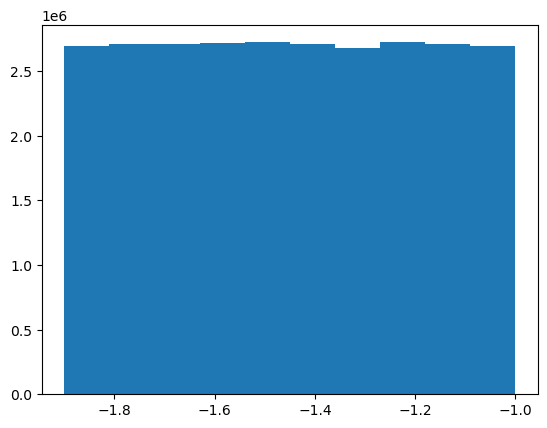

In [50]:
plt.hist(var_df['mej'])

(array([2694428., 2722137., 2693218., 2706165., 2717297., 2730486.,
        2672527., 2724194., 2701688., 2711610.]),
 array([-1.51999866, -1.42099886, -1.32199906, -1.22299927, -1.12399947,
        -1.02499967, -0.92599987, -0.82700007, -0.72800028, -0.62900048,
        -0.53000068]),
 <BarContainer object of 10 artists>)

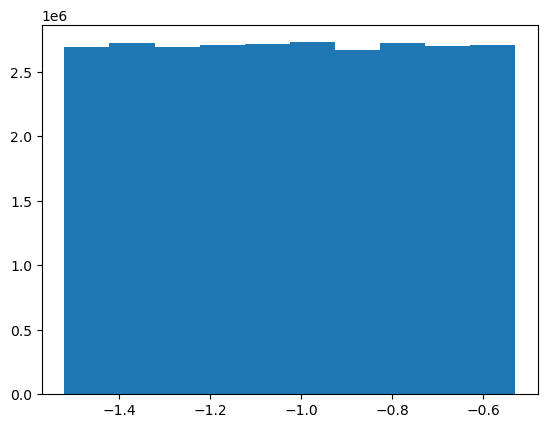

In [51]:
plt.hist(var_df['vej'])

(array([2701809., 2686321., 2698058., 2720564., 2676641., 2721411.,
        2718870., 2721532., 2720080., 2708464.]),
 array([-8.99997019, -8.39997348, -7.79997678, -7.19998008, -6.59998337,
        -5.99998667, -5.39998997, -4.79999326, -4.19999656, -3.59999986,
        -3.00000315]),
 <BarContainer object of 10 artists>)

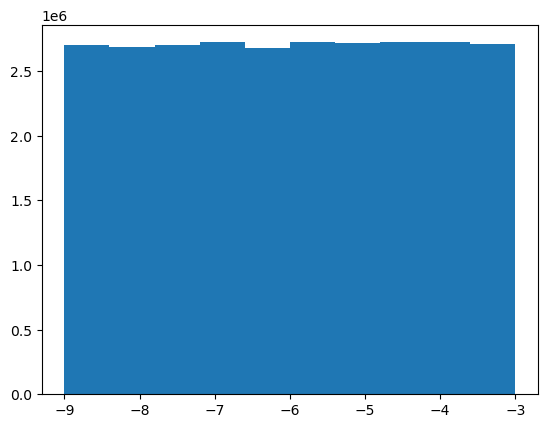

In [52]:
plt.hist(var_df['xlan'])

(array([2705802., 2727340., 2725283., 2706649., 2709190., 2680997.,
        2701809., 2683538., 2702414., 2730728.]),
 array([ 50.00077102,  65.0006598 ,  80.00054858,  95.00043736,
        110.00032614, 125.00021492, 140.0001037 , 154.99999248,
        169.99988126, 184.99977004, 199.99965882]),
 <BarContainer object of 10 artists>)

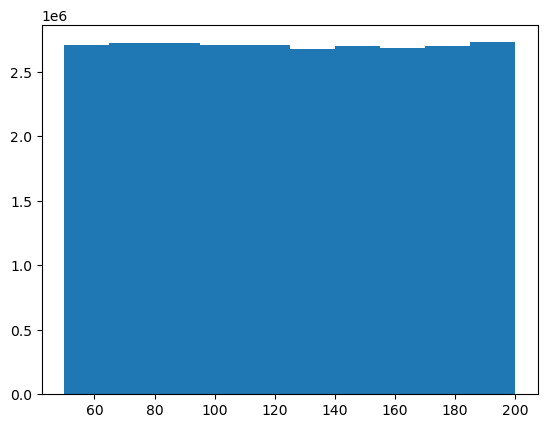

In [53]:
plt.hist(var_df['distance'])

# Prep for Flow

In [46]:
# moving the data from csv to tensors on gpu -- Don't run if tensors are already stored and available

# num_lc_flow = len(detected_df1['batch_id'].unique())
# data_shifted_flow, param_shifted_flow = test_df_to_tensor(detected_df1, num_lc_flow, 50)

In [47]:
data_shifted_flow1 = torch.load('/nobackup/users/mmdesai/updated_tensors/data_shifted_flow4.pt')
data_unshifted_flow1 = torch.load('/nobackup/users/mmdesai/updated_tensors/data_unshifted_flow4.pt')
param_shifted_flow1 = torch.load('/nobackup/users/mmdesai/updated_tensors/param_shifted_flow4.pt')
param_unshifted_flow1 = torch.load('/nobackup/users/mmdesai/updated_tensors/param_unshifted_flow4.pt')

In [48]:
data_shifted_flow2 = torch.load('/nobackup/users/mmdesai/updated_tensors/data_shifted_flow7.pt')
data_unshifted_flow2 = torch.load('/nobackup/users/mmdesai/updated_tensors/data_unshifted_flow7.pt')
param_shifted_flow2 = torch.load('/nobackup/users/mmdesai/updated_tensors/param_shifted_flow7.pt')
param_unshifted_flow2 = torch.load('/nobackup/users/mmdesai/updated_tensors/param_unshifted_flow7.pt')

In [49]:
data_shifted_flow = torch.stack(data_shifted_flow1 + data_shifted_flow2)
param_shifted_flow = torch.stack(param_shifted_flow1 + param_shifted_flow2)

In [50]:
num_lc_flow = len(data_shifted_flow)
print(num_lc_flow)

9446


In [51]:
data_shifted_flow[0].shape, param_shifted_flow[0].shape

(torch.Size([50, 3, 121]), torch.Size([50, 1, 5]))

In [52]:
dataset_normflow = Flow_data(data_shifted_flow, param_shifted_flow, num_lc_flow)

# check the dataset shape
t, d = dataset_normflow[4]
t.shape, d.shape

(torch.Size([50, 1, 5]), torch.Size([50, 3, 121]))

In [53]:
# split dataset into training, testing, and validation

train_set_size_flow = int(0.8 * num_lc_flow)    
val_set_size_flow = int(0.1 * num_lc_flow)     
test_set_size_flow = num_lc_flow - train_set_size_flow - val_set_size_flow

train_data_flow, val_data_flow, test_data_flow = torch.utils.data.random_split(
    dataset_normflow, [train_set_size_flow, val_set_size_flow, test_set_size_flow])

In [54]:
# load and shuffle the data

train_data_loader_flow = DataLoader(train_data_flow, batch_size=25, shuffle=True)
val_data_loader_flow = DataLoader(val_data_flow, batch_size=25, shuffle=True)
test_data_loader_flow = DataLoader(test_data_flow, batch_size=1, shuffle=False)

# check lengths
len(train_data_loader_flow), len(test_data_loader_flow), len(val_data_loader_flow)

(303, 946, 38)

In [55]:
# check first instance of data

for var_inj, var_data in train_data_loader_flow:
    var_inj = var_inj.reshape((-1,)+var_inj.shape[2:])
    var_data = var_data.reshape((-1,)+var_data.shape[2:])

    break
var_inj.shape, var_data.shape

(torch.Size([1250, 1, 5]), torch.Size([1250, 3, 121]))

# Histograms

In [56]:
mej_list = []
vej_list = []
xlan_list = []

for i in range(len(param_shifted_flow)):
    mej = param_shifted_flow[i][0][0][0]
    vej = param_shifted_flow[i][0][0][1]
    xlan = param_shifted_flow[i][0][0][2]
    mej_list.append(mej)
    vej_list.append(vej)
    xlan_list.append(xlan)

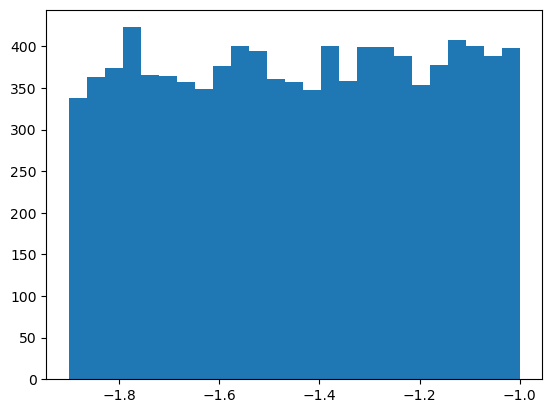

In [57]:
hist = plt.hist(mej_list, bins=25)

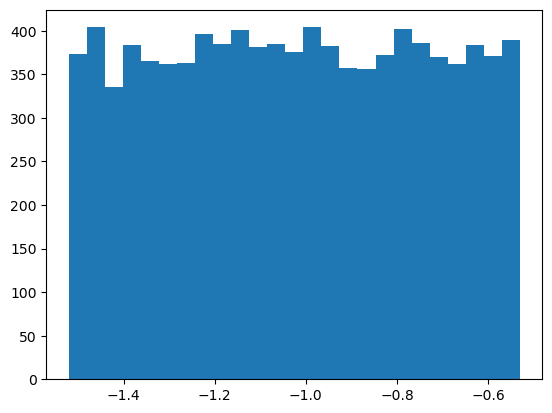

In [58]:
hist = plt.hist(vej_list, bins=25)

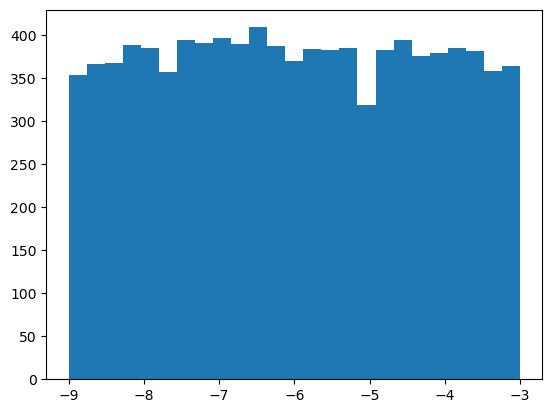

In [59]:
hist = plt.hist(xlan_list, bins=25)

In [60]:
dist_list = []
shift_list = []

for i in range(len(param_shifted_flow)):
    for j in range(0, 50):
        dist = param_shifted_flow[i][j][0][4]
        shift = param_shifted_flow[i][j][0][3]
        dist_list.append(dist)
        shift_list.append(shift)

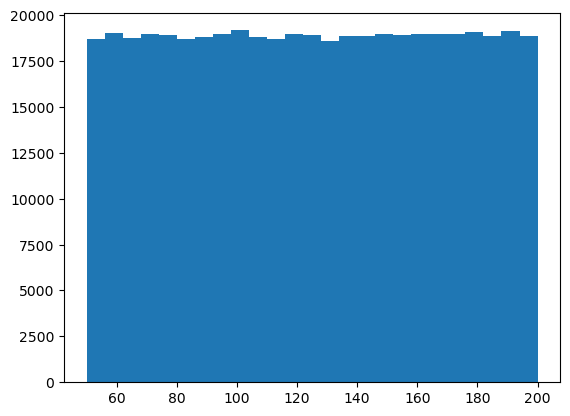

In [61]:
hist = plt.hist(dist_list, bins = 25)

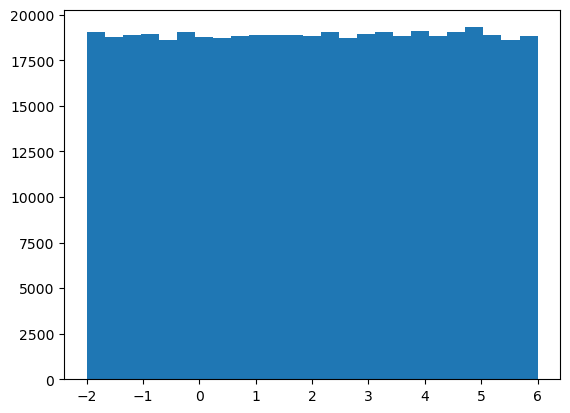

In [62]:
hist = plt.hist(shift_list, bins = 25)

# Partially Freeze the Similarity Embedding

In [64]:
for var_inj_se, var_data_se in train_data_loader_flow:
    var_inj_se = var_inj_se.reshape((-1,)+var_inj_se.shape[2:]).to(device)
    var_data_se = var_data_se.reshape((-1,)+var_data_se.shape[2:]).to(device)
    break

# check shapes
print(var_data_se.shape, var_inj_se.shape)
_, rep = similarity_embedding(var_data_se)  # _.shape = batch_size x 1 x 10, # rep.shape = batch_size x 1 x 2
print(_.shape, rep.shape)
context_features = rep.shape[-1]
print('number of context_features: ', context_features)
print('number of dimensions: ', num_dim)

torch.Size([1250, 3, 121]) torch.Size([1250, 1, 5])
torch.Size([1250, 5]) torch.Size([1250, 7])
number of context_features:  7
number of dimensions:  7


In [65]:
# define parameters

transform, base_dist, embedding_net = normflow_params(similarity_embedding, 9, 5, 90, context_features=context_features, num_dim=num_dim) 

In [66]:
flow = Flow(transform, base_dist, embedding_net).to(device=device)

In [67]:
print('Total number of trainable parameters: ', sum(p.numel() for p in flow.parameters() if p.requires_grad))

Total number of trainable parameters:  1194255


In [69]:
for idx, val in enumerate(train_data_loader_flow, 1):
    augmented_shift, augmented_data = val
    augmented_shift = augmented_shift[...,0:3].to(device)
    augmented_shift = augmented_shift.flatten(0, 2).to(device)
    augmented_data = augmented_data.reshape(-1, 3, num_points).to(device)
    print(augmented_shift.shape, augmented_data.shape)
    break

torch.Size([1250, 3]) torch.Size([1250, 3, 121])


In [70]:
similarity_embedding(augmented_data)[0].shape, similarity_embedding(augmented_data)[1].shape

(torch.Size([1250, 5]), torch.Size([1250, 7]))

In [71]:
flow_loss = -flow.log_prob(augmented_shift, context=augmented_data).mean()
flow_loss

tensor(12.5382, device='cuda:0', grad_fn=<NegBackward0>)

# Train and Validate

In [72]:
# optimizer
optimizer = optim.SGD(flow.parameters(), lr=0.0000912, momentum=0.5)
# scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2, factor=0.5, threshold=0.001)

In [73]:
writer = SummaryWriter()

In [79]:
%%time
# UNCOMMENT AND RUN TO TRAIN FROM SCRATCH

train_loss_list = []
val_loss_list = []

EPOCHS = 50
epoch_number = 0
for epoch in range(EPOCHS):
    print('EPOCH {}:'.format(epoch_number + 1))
    flow.train(True)
    for name, param in flow._embedding_net.named_parameters():
        param.requires_grad = True
    avg_train_loss = train_one_epoch(epoch_number, writer, train_data_loader_flow, flow, optimizer, 2)
    train_loss_list.append(avg_train_loss)
    flow.train(False)
    avg_val_loss = val_one_epoch(epoch_number, writer, val_data_loader_flow, flow, 2)
    val_loss_list.append(avg_val_loss)
    print(f"Train/Val flow Loss after epoch: {avg_train_loss:.4f}/{avg_val_loss:.4f}")
    epoch_number += 1
    scheduler.step(avg_val_loss)
    for param_group in optimizer.param_groups:
        print("Current LR = {:.3e}".format(param_group['lr']))

EPOCH 1:
 Avg. train loss/batch after 10 batches = 11.2850
 Avg. train loss/batch after 20 batches = 10.1889
 Avg. train loss/batch after 30 batches = 9.1144
 Avg. train loss/batch after 40 batches = 7.9500
 Avg. train loss/batch after 50 batches = 6.7877
 Avg. train loss/batch after 60 batches = 5.7140
 Avg. train loss/batch after 70 batches = 4.7000
 Avg. train loss/batch after 80 batches = 3.8829
 Avg. train loss/batch after 90 batches = 3.2992
 Avg. train loss/batch after 100 batches = 2.9109
 Avg. train loss/batch after 110 batches = 2.5876
 Avg. train loss/batch after 120 batches = 2.3594
 Avg. train loss/batch after 130 batches = 2.1897
 Avg. train loss/batch after 140 batches = 2.0144
 Avg. train loss/batch after 150 batches = 1.9138
 Avg. train loss/batch after 160 batches = 1.8414
 Avg. train loss/batch after 170 batches = 1.7235
 Avg. train loss/batch after 180 batches = 1.6526
 Avg. train loss/batch after 190 batches = 1.5815
 Avg. train loss/batch after 200 batches = 1.551

# Weights

In [80]:
# save normalizing flow weights

PATH_nflow = '/nobackup/users/mmdesai/flow_weights_tutorial.pth'
torch.save(flow.state_dict(), PATH_nflow)

In [26]:
# load the normalizing flow weights

context_features = 7
transform, base_dist, embedding_net = normflow_params(similarity_embedding, 9, 5, 90, context_features=context_features, num_dim=num_dim) 
flow = Flow(transform, base_dist, embedding_net).to(device=device)

PATH_nflow = '/nobackup/users/mmdesai/flow_weights_tutorial.pth'
flow.load_state_dict(torch.load(PATH_nflow, map_location=device))

<All keys matched successfully>

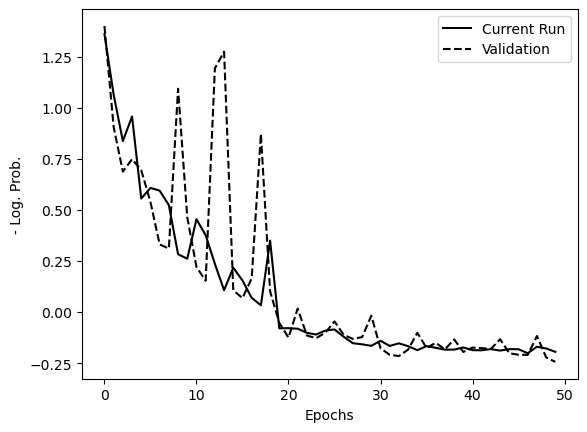

In [81]:
# plot the comparision of the train/val loss for the three scenarios

epoch_list = range(0,200)

plt.plot(epoch_list[:len(train_loss_list)], train_loss_list[:len(train_loss_list)], label = 'Current Run', color = 'k')
plt.plot(epoch_list[:len(val_loss_list)], val_loss_list[:len(val_loss_list)], label = 'Validation', color = 'k', linestyle = 'dashed')
plt.ylabel('- Log. Prob.')
plt.xlabel('Epochs')
plt.legend()

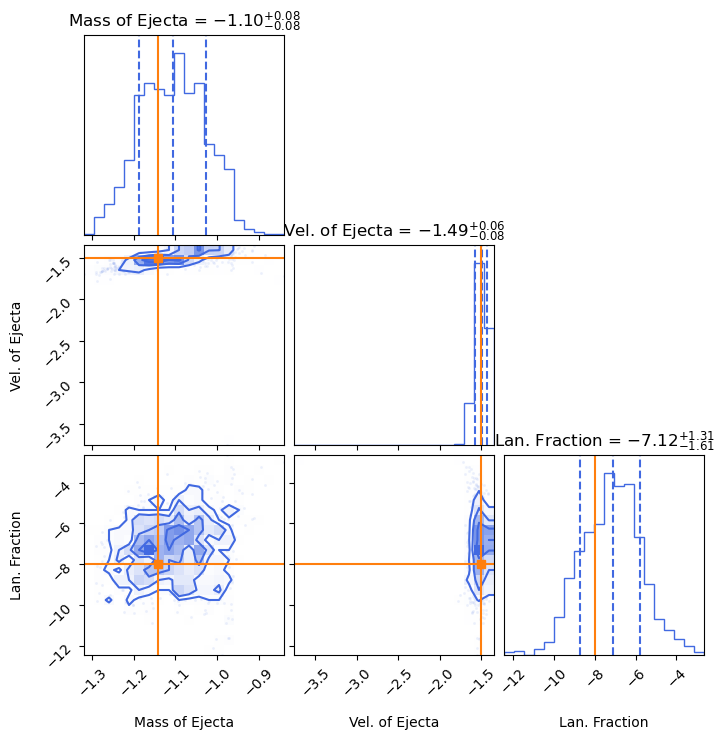

In [27]:
for idx, (shift_test, data_test) in enumerate(test_data_loader_flow):
    data_test = data_test.reshape((-1,)+data_test.shape[2:])
    shift_test = shift_test.reshape((-1,)+shift_test.shape[2:])
    if idx % 100 !=0: continue 
    with torch.no_grad():
        samples = flow.sample(1000, context=data_test[0].reshape((1, 3, num_points)))
    live_plot_samples(samples.cpu().reshape(1000,3), shift_test[0][0].cpu()[...,0:3])
    plt.show()